In [12]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import os, sys
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import torch
from scipy import stats


sys.path.insert(0, 'src')
from utils.utils import read_lists, load_image, ensure_dir
from utils.visualizations import histogram, plot, show_image_rows, bar_graph
from utils.df_utils import convert_string_columns


In [2]:
RESULTS_DIR = os.path.join('saved', 'ADE20K', 'survey_results', 'ADE20K_soft_labels')
MEASUREMENT_COLUMN_NAMES = ['selectedAttrs', 'attrUncs']
TASK_METADATA_COLUMN_NAMES = ['filename', 'task', 'concept_group']
EXPLAINER_DIRNAME = 'saved/PlacesCategoryClassification/0510_102912/ADE20K_predictions/saga/KD_baseline_explainer/hparam_search/0523_164052/best'

CONGRUENCY_PATH_TEMPLATE = os.path.join(EXPLAINER_DIRNAME, '{}_paths.txt')
CONGRUENT_PATHS_PATH = CONGRUENCY_PATH_TEMPLATE.format('congruent')
INCONGRUENT_PATHS_PATH = CONGRUENCY_PATH_TEMPLATE.format('incongruent')

MODEL_DIRNAME = 'saved/PlacesCategoryClassification/0510_102912/ADE20K_predictions/saga'
# Path to where images in ADE20K are stored. (Prefix to path in congruent/incongruent paths files)
ADE20K_PARENT_DIR = os.path.join('data', 'broden1_224', 'images')
CSV_SAVE_PATH = os.path.join(os.path.dirname(RESULTS_DIR), 'processed_results_{}_samples.csv')



### Obtain list of CSV paths in `RESULTS_DIR`, load congruent and incongruent paths

In [37]:
csv_paths = []

for filename in os.listdir(RESULTS_DIR):
    if filename.endswith('csv'):
        csv_paths.append(os.path.join(RESULTS_DIR, filename))

csv_paths = sorted(csv_paths)
# Load congruent/incongruent paths
congruent_paths = set(read_lists(CONGRUENT_PATHS_PATH))
incongruent_paths = set(read_lists(INCONGRUENT_PATHS_PATH))


### Clean the dataframes and merge to 1 dataframe

In [38]:
df_list = []
for csv_path in csv_paths:
    print("Processing {}".format(os.path.basename(csv_path))) 
    df = pd.read_csv(csv_path)
    # Separate dataframe into rows with measurements and with metadata
    measurement_df = df[MEASUREMENT_COLUMN_NAMES]
    metadata_df = df.drop(MEASUREMENT_COLUMN_NAMES, axis=1)

    # Drop empty rows
    measurement_df = measurement_df.dropna()
    # Drop rows without data in task metadata columns
    metadata_df = metadata_df.dropna(subset=TASK_METADATA_COLUMN_NAMES)

    # Remove columns that are empty
    metadata_df = metadata_df.dropna(axis=1)
    
    # for each image, add a column for whether it is a congruent or incongruent example
    congruents = []
    for filename in metadata_df['filename']:
        path = os.path.join(ADE20K_PARENT_DIR, filename)
        if path in congruent_paths:
            congruents.append(1)
        elif path in incongruent_paths:
            congruents.append(0)
        else:
            raise ValueError("Path {} not found in congruent or incongruent paths... :0".format(path))
    metadata_df['congruent'] = congruents

    # Assert that the two DFs have the same number of rows
    assert len(metadata_df) == len(measurement_df), "Uneven length data frames. Metadata length: {} Measurement length: {}".format(
        len(metadata_df), len(measurement_df))

    # Reset indices to allow for joining appropriately
    metadata_df = metadata_df.reset_index(drop=True)
    measurement_df = measurement_df.reset_index(drop=True)


    # Join the data frames
    df = pd.concat([metadata_df, measurement_df], axis=1)
    assert len(df) == len(metadata_df)

    # Add dataframe to list of dataframes
    df_list.append(df)
    
# Concatenate rows of all dataframes together
df = pd.concat(df_list)

n_congruent = len(df[df['congruent'] == 1])
n_incongruent = len(df[df['congruent'] == 0])
print("Total of {} congruent samples and {} incongruent samples".format(n_congruent, n_incongruent))


Processing 000_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h26.47.486.csv
Processing 001_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h35.07.423.csv
Processing 002_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h40.48.508.csv
Processing 003_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h48.15.198.csv
Processing 004_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_17h55.01.103.csv
Processing 005_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_18h00.12.78.csv
Processing 006_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_18h05.33.934.csv
Processing 007_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-03_18h11.11.320.csv
Processing 008_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-04_09h23.31.131.csv
Processing 009_uncertainty-annotation_PARTICIPANT_SESSION_2023-05-04_09h28.52.510.csv
Total of 190 congruent samples and 110 incongruent samples


In [40]:
save_path = CSV_SAVE_PATH.format(len(df))

if os.path.exists(save_path):
    print("Path {} already exists".format(save_path))
else:
    df.to_csv(save_path)
    print("Saving results to {}".format(save_path))

Saving results to saved/ADE20K/survey_results/processed_results_300_samples.csv


### Process each uncertainty attribute vector to soft_labels, compute 1) entropy and 2) confusion

In [41]:
SCENE_CATEGORIES_PATH = os.path.join('data', 'ade20k', 'scene_categories.txt')
n_samples = 300

csv_path = CSV_SAVE_PATH.format(n_samples)

# Create a 2-way dictionary mapping from category <-> index
scene_categories = read_lists(SCENE_CATEGORIES_PATH)
scene_categories_dict = {}
for idx, category in enumerate(scene_categories):
    scene_categories_dict[idx] = category
    scene_categories_dict[category] = idx
n_categories = len(scene_categories)

# Load CSV
df = pd.read_csv(csv_path)

In [42]:
def get_top_2_confusion(soft_labels):
    '''
    Given soft label distribution, calculate difference between top 2 labels

    Arg(s):
        soft_labels : N x C np.array
            soft label array for N samples and C class predictions

    Returns:
        confusion : N-dim np.array
            confusion for each sample
    '''
    # Sort soft labels ascending
    sorted_soft_labels = np.sort(soft_labels, axis=-1)
    # Calculate difference of p(x) for top 2 classes
    top_2_difference = sorted_soft_labels[:, -1] - sorted_soft_labels[:, -2]
    # Confusion = 1 - difference (higher is worse)
    top_2_confusion = 1 - top_2_difference

    return top_2_confusion


#### Calculate soft labels, and predictions

In [43]:
# if 'human_probabilities' not in df.columns:
print("Calculating soft labels")
human_soft_labels = []
unnormalized_human_soft_labels = []
human_predictions = []
for row in tqdm(df['attrUncs']):
    soft_label = np.zeros(n_categories)
    # Each 'score' item is a dictionary of class and certainty amount
    row = json.loads(row)
    for item in row:
        category = item['label']
        certainty = item['y'] / 100.0
        category_idx = scene_categories_dict[category]
        soft_label[category_idx] = certainty
    label_sum = np.sum(soft_label)
    unnormalized_human_soft_labels.append(soft_label)
    # Distribute remaining mass across other classes
    # if label_sum < 1.0:
    #     remaining = 1.0 - label_sum
    #     n_classes_left = n_categories - np.count_nonzero(soft_label)
    #     remaining_per_class = remaining / n_classes_left
    #     soft_label = np.where(soft_label == 0, remaining_per_class, soft_label)    
    # # Normalize to sum to 1
    # elif label_sum > 1.0:
        # soft_label = soft_label / label_sum

    # Normalize to sum to one
    soft_label = soft_label / label_sum
    # Assert the soft label sums to 1
    assert np.abs(np.sum(soft_label) - 1.0) < 1e-5

    human_soft_labels.append(soft_label)
    human_predictions.append(np.argmax(soft_label))

df['human_probabilities'] = human_soft_labels
df['human_outputs'] = unnormalized_human_soft_labels
df['human_predictions'] = human_predictions
print("Calculated soft labels")
# else:
    # print("Soft labels already in dataframe")



Calculating soft labels


100%|██████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 29040.39it/s]

Calculated soft labels


### Add the model's and explainer's soft labels to the dataframe

In [44]:
# Obtain explainer softmax probabilities
explainer_outputs_path = os.path.join(EXPLAINER_DIRNAME, 'val_outputs_predictions.pth')
explainer_out = torch.load(explainer_outputs_path)
explainer_probabilities = explainer_out['probabilities']

# Obtainer model's softmax probabilities
model_outputs_path = os.path.join(MODEL_DIRNAME, 'val_outputs_predictions.pth')
model_out = torch.load(model_outputs_path)
model_probabilities = model_out['probabilities']

# Obtain mapping from image name to index of validation set
image_labels_path = 'data/ade20k/full_ade20k_imagelabels.pth'
image_labels = torch.load(image_labels_path)
val_images = image_labels['val']
val_images = [path.split('images/')[-1] for path in val_images]
val_name_idx_dict = {}
for idx, image_name in enumerate(val_images):
    val_name_idx_dict[image_name] = idx


# For each row in the data frame, store the explainers' and models' outputs
for name, outputs in zip(['explainer', 'model'], [explainer_out, model_out]):
    for output_type in ['outputs', 'probabilities', 'predictions']:
        cur_outputs = outputs[output_type]
        accumulator = []
        for image_name in df['filename']:
            val_idx = val_name_idx_dict[image_name]
            cur_item = cur_outputs[val_idx]
            accumulator.append(cur_item)
        df['{}_{}'.format(name, output_type)] = accumulator
        
    # add entropy and t2c for model
    # if name == 'model':
    cur_probabilities = np.stack(df['{}_probabilities'.format(name)].to_numpy(), axis=0)
    cur_outputs = np.stack(df['{}_outputs'.format(name)].to_numpy(), axis=0)
    cur_entropy = stats.entropy(cur_probabilities, axis=1)
    cur_t2c = get_top_2_confusion(cur_outputs)
    # Min-max scale t2c to be between [0, 1]
    min_t2c = np.amin(cur_t2c)
    max_t2c = np.amax(cur_t2c)
    scaled_cur_t2c = (cur_t2c - min_t2c) / (max_t2c - min_t2c)
    df['{}_entropy'.format(name)] = cur_entropy
    df['{}_t2c'.format(name)] = cur_t2c
    df['{}_scaled_t2c'.format(name)] = scaled_cur_t2c
        
print("Added model and explainer's outputs, probabilities, and predictions to dataframe")
print("Added model and explainer entropy, t2c to dataframe")

Added model and explainer's outputs, probabilities, and predictions to dataframe
Added model and explainer entropy, t2c to dataframe


### Calculate entropy and KL divergence

In [45]:
# Calculate entropy
entropy = stats.entropy(human_soft_labels, axis=1)
df['human_entropy'] = entropy

# Top 2 confusion
human_t2c = get_top_2_confusion(unnormalized_human_soft_labels)
df['human_t2c'] = human_t2c

# KL divergence between model-explainer
p = np.stack(df['explainer_probabilities'], axis=0)
q = np.stack(df['model_probabilities'], axis=0)
kl_model_explainer = stats.entropy(pk=p, qk=q, axis=1)
df['kl_model_explainer'] = kl_model_explainer

### Save Results, overwriting DF

In [46]:
# Create a dictionary
human_soft_labels_arr = np.stack(human_soft_labels, axis=0)
print(human_soft_labels_arr.shape)
data = {
    "filename": df['filename'],
    "congruent": df['congruent'],
    "soft_label": human_soft_labels_arr,
    "entropy": entropy,
    "human_t2c": human_t2c
}
df.to_csv(csv_path)
print("Saved csv with soft labels to {}".format(csv_path))
pth_path = csv_path.replace('csv', 'pth')
torch.save(data, pth_path)
print("Saved dictionary with filenames, congruency, and soft labels to {}".format(pth_path))
    


(300, 16)
Saved csv with soft labels to saved/ADE20K/survey_results/processed_results_300_samples.csv
Saved dictionary with filenames, congruency, and soft labels to saved/ADE20K/survey_results/processed_results_300_samples.pth


# Examine Results

In [47]:
csv_path = 'saved/ADE20K/survey_results/processed_results_300_samples.csv'
df = pd.read_csv(csv_path)

## IV: confusion DV: % alignment

#### Define functions

In [64]:
def sort_and_bin_df(df, sort_columns, n_bins):
    n_per_bin = len(df) // n_bins
    n_extra = len(df) % n_bins
    sorted_df = df.sort_values(sort_columns, ascending=True, ignore_index=True)

    # DV: proportion of images where the human and explainer disagree
    temp_df = df.copy()
    bin_rows = []
    iv_means = []
    start_idx = 0
    for bin_idx in range(n_bins):
        if bin_idx < n_extra:
            end_idx = start_idx + n_per_bin + 1
        else:
            end_idx = start_idx + n_per_bin
        cur_rows = sorted_df.iloc[start_idx:end_idx]

        bin_rows.append(cur_rows)
        iv_means.append(cur_rows[sort_columns[0]].mean())
        start_idx = end_idx
    return bin_rows, iv_means

def calculate_bin_disagreement(bin_rows,
                               agent1,
                               agent2):
    agents = ['human', 'explainer', 'model']
    assert agent1 in agents
    assert agent2 in agents
    
    disagreements = []
    for rows in bin_rows:
        assert '{}_predictions'.format(agent1) in rows.columns and \
            '{}_predictions'.format(agent2) in rows.columns
        agent1_preds = rows['{}_predictions'.format(agent1)].to_numpy()
        agent2_preds = rows['{}_predictions'.format(agent2)].to_numpy()
        disagreement = np.count_nonzero(agent1_preds != agent2_preds) / len(rows)
        disagreements.append(disagreement)
    return disagreements

def calculate_bin_agreement(bin_rows,
                               agent1,
                               agent2):
    agents = ['human', 'explainer', 'model']
    assert agent1 in agents
    assert agent2 in agents
    
    agreements = []
    for rows in bin_rows:
        assert '{}_predictions'.format(agent1) in rows.columns and \
            '{}_predictions'.format(agent2) in rows.columns
        agent1_preds = rows['{}_predictions'.format(agent1)].to_numpy()
        agent2_preds = rows['{}_predictions'.format(agent2)].to_numpy()
        agreement = np.count_nonzero(agent1_preds == agent2_preds) / len(rows)
        agreements.append(agreement)
    return agreements

In [65]:
import time
# from utils.visualizations import plot
def plot_agreement(df, 
                   iv_names, 
                   n_bins, 
                   save_graph_dir,
                   save_separate=True,):
    # iv_names = ['human_entropy', 'human_t2c']
    bin_rows, iv_means = sort_and_bin_df(
        df=df,
        sort_columns=iv_names,
        n_bins=n_bins)

    agreement_he = calculate_bin_agreement(
        bin_rows=bin_rows,
        agent1='human',
        agent2='explainer')

    agreement_hm = calculate_bin_agreement(
        bin_rows=bin_rows,
        agent1='human',
        agent2='model')

    agreement_me = calculate_bin_agreement(
        bin_rows=bin_rows,
        agent1='model',
        agent2='explainer')

    # dvs = [agreement_he, agreement_hm, agreement_me]
    dvs = OrderedDict({
        ('human', 'explainer'): agreement_he,
        ('human', 'model'): agreement_hm,
        ('model', 'explainer'): agreement_me
    })
    # Plot 
    # plt.clf()
    
    if not save_separate:
        fig = plt.figure(figsize=(6, 12))
        axs = fig.subplots(3, 1)
        
    for idx, (key, dv) in enumerate(dvs.items()):
        agent1, agent2 = key
        if not save_separate:
            ax = axs[idx]
        pearsons = stats.pearsonr(
            x=iv_means,
            y=dv)
        print("Pearson's linear correlation coefficient: {:.3f} (p={:.6f}".format(
            pearsons.statistic, pearsons.pvalue))
        slope, yint, r, p, std_err = stats.linregress(iv_means, dv)
        r_squared = r ** 2
        print("Line of best fit: y={:.2f}x+{:.2f}; R-squared: {:.3f} p-val: {:.3f}".format(
            slope, yint, r_squared, p))
        if save_separate:
            save_path = os.path.join(save_graph_dir, '{}_{}_agree_v_{}.png'.format(agent1, agent2, iv_names[0]))
            # plt.pause(0.0001)
            fig = None
            ax = None
            # plt.clf()
        else:
            save_path = None
        fig, ax = plot(
            xs=[iv_means],
            ys=[dv],
            fig=fig,
            ax=ax,
            xlabel='Mean {} for bin (n_bins={})'.format(iv_names[0], n_bins),
            ylabel='% of samples where {} and {} agree'.format(agent1, agent2),
            labels=['Pearsons: {:.3f} (p={:.6f})\ny={:.2f}x+{:.2f}; R-squared: {:.3f}'.format(
                pearsons.statistic, pearsons.pvalue, slope, yint, r_squared)],
            ylimits=[0, 1],
            title='% of agreeance given {}'.format(iv_names[0]),
            line=True,
            show=save_separate,
            save_path=save_path)
        # plt.show()
        # time.sleep(1)
        if not save_separate:
            axs[idx] = ax
            print(axs[idx].get_ylabel())
  
    if not save_separate:
        fig_save_path = os.path.join(save_graph_dir, 'multi_agree_v_{}.png'.format(iv_names[0])) 
        plt.savefig(fig_save_path)
        plt.show()
    # plt.clf()
    plot(
        xs=[iv_means for i in range(len(dvs))],
        ys=list(dvs.values()),
        xlabel='Mean {} for bin (n_bins={})'.format(iv_names[0], n_bins),
        ylabel='% of samples where agents agree',
        ylimits=[0, 1],
        labels=list(dvs.keys()),
        title='% of agreeance given {}'.format(iv_names[0]),
        line=True,
        show=True,
        save_path=os.path.join(save_graph_dir,'all_agree_v_{}.png'.format(iv_names[0])))

In [99]:
csv_path = 'saved/ADE20K/survey_results/processed_results_300_samples.csv'
df = pd.read_csv(csv_path)
    
graph_dir = os.path.join(os.path.dirname(csv_path), 'graphs')
ensure_dir(graph_dir)

### RQ: For each confusion metric, which alignment does it best predict?

Group by confusion metric

#### IV: human confusion; DV: % of images the human and explainer agree; % of images the model and explainer agree

Pearson's linear correlation coefficient: -0.760 (p=0.001017
Line of best fit: y=-0.53x+0.66; R-squared: 0.577 p-val: 0.001


<Figure size 432x288 with 0 Axes>

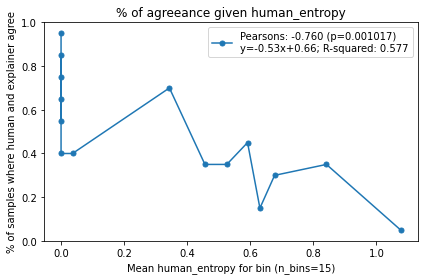

Pearson's linear correlation coefficient: -0.833 (p=0.000115
Line of best fit: y=-0.56x+0.84; R-squared: 0.694 p-val: 0.000


<Figure size 432x288 with 0 Axes>

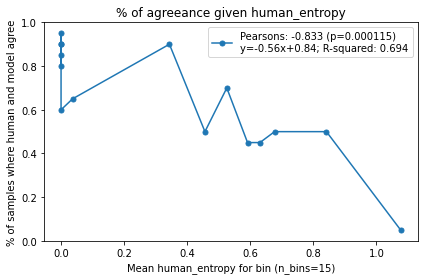

Pearson's linear correlation coefficient: -0.525 (p=0.044631
Line of best fit: y=-0.18x+0.70; R-squared: 0.275 p-val: 0.045


<Figure size 432x288 with 0 Axes>

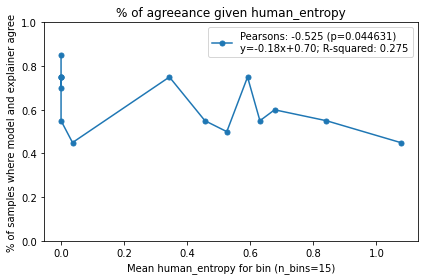

<Figure size 432x288 with 0 Axes>

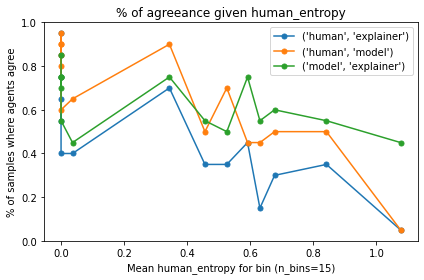

Pearson's linear correlation coefficient: -0.760 (p=0.001017
Line of best fit: y=-0.53x+0.66; R-squared: 0.577 p-val: 0.001
% of samples where human and explainer agree
Pearson's linear correlation coefficient: -0.833 (p=0.000115
Line of best fit: y=-0.56x+0.84; R-squared: 0.694 p-val: 0.000
% of samples where human and model agree
Pearson's linear correlation coefficient: -0.525 (p=0.044631
Line of best fit: y=-0.18x+0.70; R-squared: 0.275 p-val: 0.045
% of samples where model and explainer agree


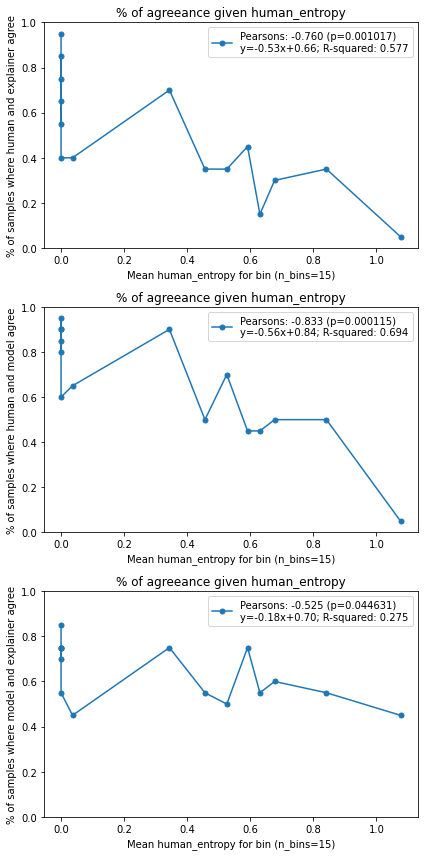

<Figure size 432x288 with 0 Axes>

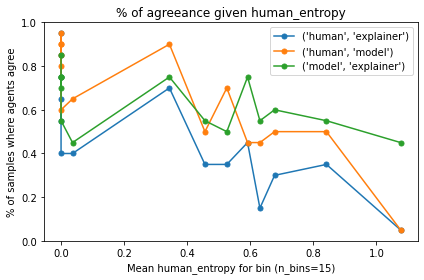

In [66]:
iv_names = ['human_entropy', 'human_t2c']
n_bins = 15
save_graph_dir = os.path.join(graph_dir, 'human_confusion')
ensure_dir(save_graph_dir)
plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir,
    save_separate=False)

Pearson's linear correlation coefficient: -0.866 (p=0.000030
Line of best fit: y=-0.67x+0.71; R-squared: 0.750 p-val: 0.000


<Figure size 432x288 with 0 Axes>

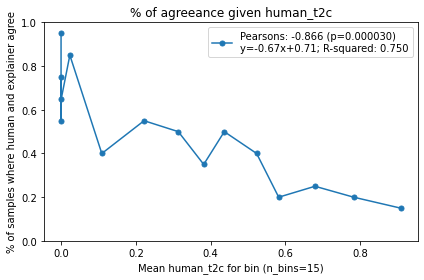

Pearson's linear correlation coefficient: -0.906 (p=0.000003
Line of best fit: y=-0.65x+0.86; R-squared: 0.820 p-val: 0.000


<Figure size 432x288 with 0 Axes>

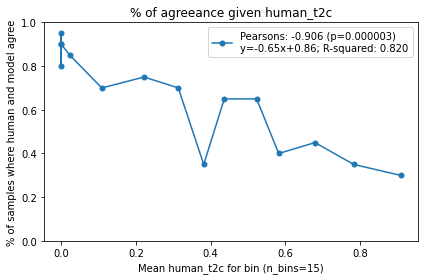

Pearson's linear correlation coefficient: -0.705 (p=0.003319
Line of best fit: y=-0.27x+0.72; R-squared: 0.497 p-val: 0.003


<Figure size 432x288 with 0 Axes>

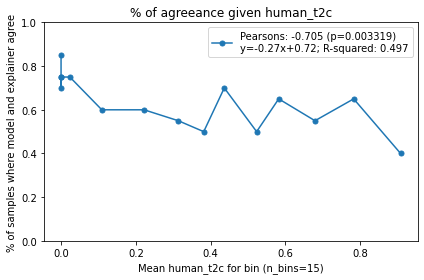

<Figure size 432x288 with 0 Axes>

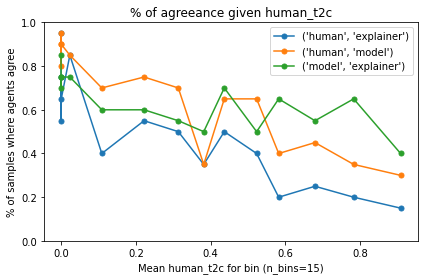

Pearson's linear correlation coefficient: -0.866 (p=0.000030
Line of best fit: y=-0.67x+0.71; R-squared: 0.750 p-val: 0.000
% of samples where human and explainer agree
Pearson's linear correlation coefficient: -0.906 (p=0.000003
Line of best fit: y=-0.65x+0.86; R-squared: 0.820 p-val: 0.000
% of samples where human and model agree
Pearson's linear correlation coefficient: -0.705 (p=0.003319
Line of best fit: y=-0.27x+0.72; R-squared: 0.497 p-val: 0.003
% of samples where model and explainer agree


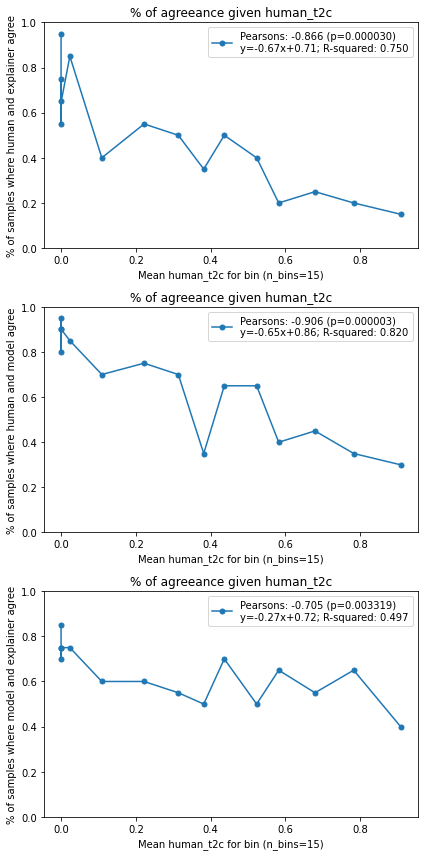

<Figure size 432x288 with 0 Axes>

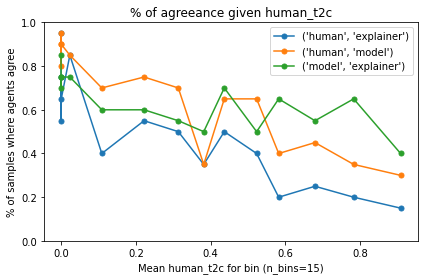

In [67]:
iv_names = ['human_t2c', 'human_entropy']
n_bins = 15
save_graph_dir = os.path.join(graph_dir, 'human_confusion')
ensure_dir(save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir,
    save_separate=False)


#### IV: model confusion; DV: % of images the human and explainer agree; % of images the model and explainer agree

Pearson's linear correlation coefficient: -0.938 (p=0.000000
Line of best fit: y=-0.41x+0.95; R-squared: 0.880 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

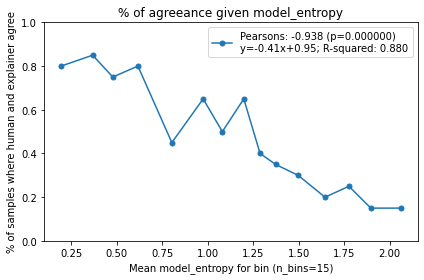

Pearson's linear correlation coefficient: -0.855 (p=0.000049
Line of best fit: y=-0.26x+0.95; R-squared: 0.731 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

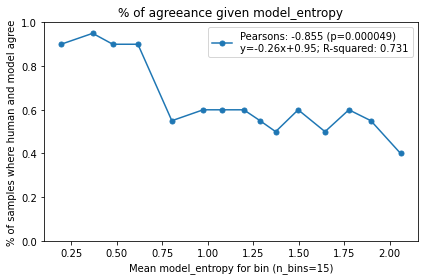

Pearson's linear correlation coefficient: -0.908 (p=0.000003
Line of best fit: y=-0.30x+0.97; R-squared: 0.825 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

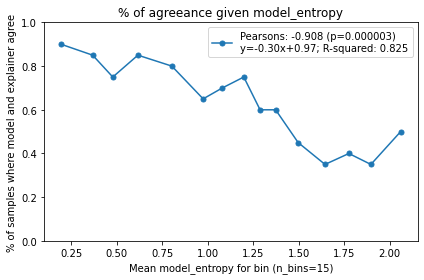

hi


<Figure size 432x288 with 0 Axes>

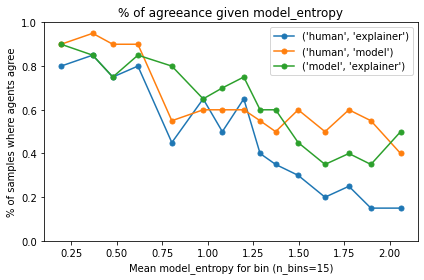

Pearson's linear correlation coefficient: -0.938 (p=0.000000
Line of best fit: y=-0.41x+0.95; R-squared: 0.880 p-val: 0.000
hi
% of samples where human and explainer agree
Pearson's linear correlation coefficient: -0.855 (p=0.000049
Line of best fit: y=-0.26x+0.95; R-squared: 0.731 p-val: 0.000
hi
% of samples where human and model agree
Pearson's linear correlation coefficient: -0.908 (p=0.000003
Line of best fit: y=-0.30x+0.97; R-squared: 0.825 p-val: 0.000
hi
% of samples where model and explainer agree


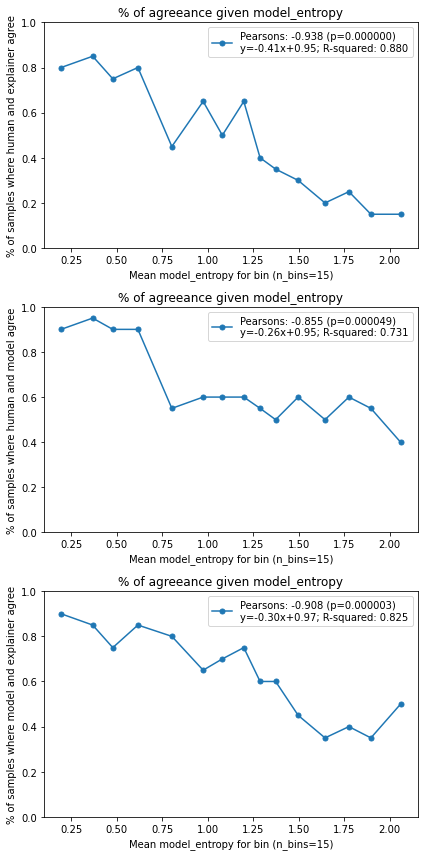

hi


<Figure size 432x288 with 0 Axes>

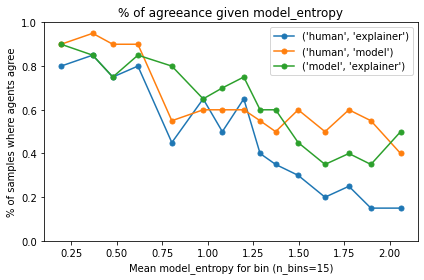

In [444]:
iv_names = ['model_entropy', 'model_scaled_t2c']
n_bins = 15
save_graph_dir = os.path.join(graph_dir, 'model_confusion')
ensure_dir(save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir,
    save_separate=False)

Pearson's linear correlation coefficient: -0.881 (p=0.000014
Line of best fit: y=-1.00x+1.20; R-squared: 0.776 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

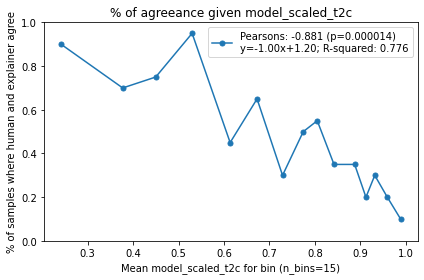

Pearson's linear correlation coefficient: -0.872 (p=0.000022
Line of best fit: y=-0.70x+1.15; R-squared: 0.761 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

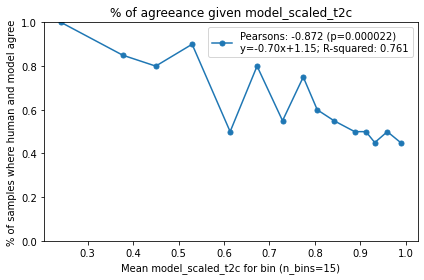

Pearson's linear correlation coefficient: -0.795 (p=0.000401
Line of best fit: y=-0.74x+1.16; R-squared: 0.631 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

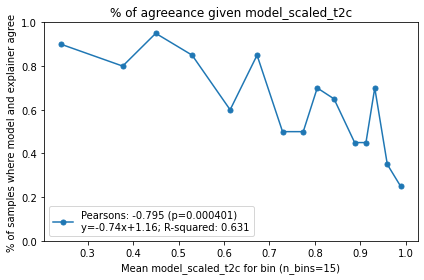

hi


<Figure size 432x288 with 0 Axes>

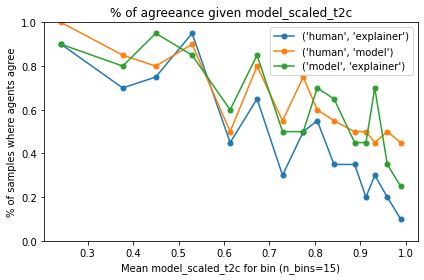

Pearson's linear correlation coefficient: -0.881 (p=0.000014
Line of best fit: y=-1.00x+1.20; R-squared: 0.776 p-val: 0.000
hi
% of samples where human and explainer agree
Pearson's linear correlation coefficient: -0.872 (p=0.000022
Line of best fit: y=-0.70x+1.15; R-squared: 0.761 p-val: 0.000
hi
% of samples where human and model agree
Pearson's linear correlation coefficient: -0.795 (p=0.000401
Line of best fit: y=-0.74x+1.16; R-squared: 0.631 p-val: 0.000
hi
% of samples where model and explainer agree


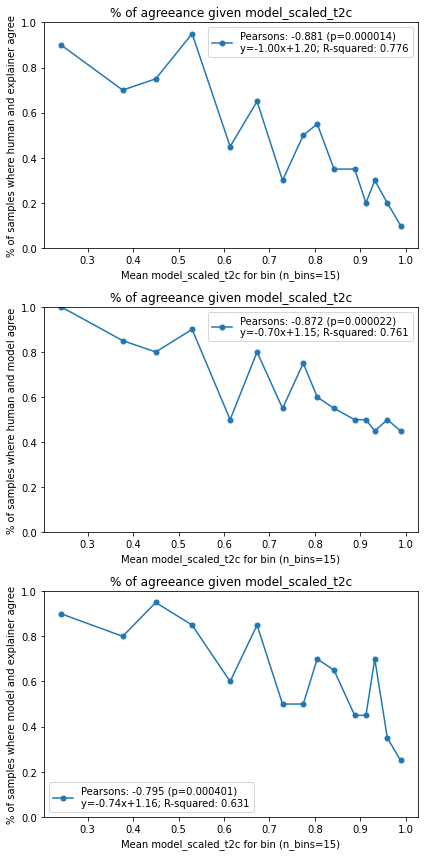

hi


<Figure size 432x288 with 0 Axes>

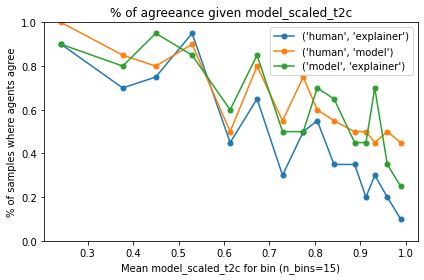

In [433]:
iv_names = ['model_scaled_t2c', 'model_entropy']
n_bins = 15
save_graph_dir = os.path.join(graph_dir, 'model_confusion')
ensure_dir(save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir,
    save_separate=False)

#### IV: explainer confusion; DV: % of images the human and explainer agree; % of images the model and explainer agree

Pearson's linear correlation coefficient: -0.890 (p=0.000000
Line of best fit: y=-0.44x+1.20; R-squared: 0.792 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

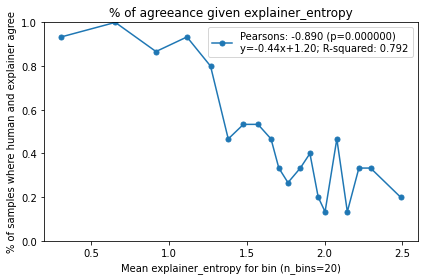

Pearson's linear correlation coefficient: -0.839 (p=0.000004
Line of best fit: y=-0.30x+1.13; R-squared: 0.704 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

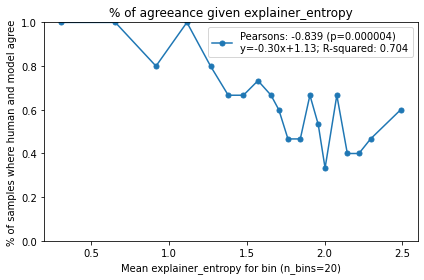

Pearson's linear correlation coefficient: -0.895 (p=0.000000
Line of best fit: y=-0.35x+1.20; R-squared: 0.800 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

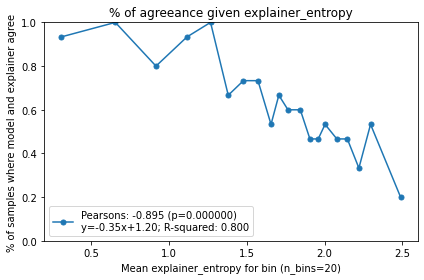

hi


<Figure size 432x288 with 0 Axes>

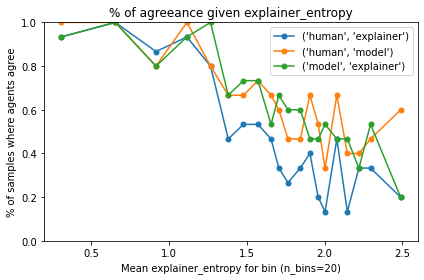

Pearson's linear correlation coefficient: -0.890 (p=0.000000
Line of best fit: y=-0.44x+1.20; R-squared: 0.792 p-val: 0.000
hi
% of samples where human and explainer agree
Pearson's linear correlation coefficient: -0.839 (p=0.000004
Line of best fit: y=-0.30x+1.13; R-squared: 0.704 p-val: 0.000
hi
% of samples where human and model agree
Pearson's linear correlation coefficient: -0.895 (p=0.000000
Line of best fit: y=-0.35x+1.20; R-squared: 0.800 p-val: 0.000
hi
% of samples where model and explainer agree


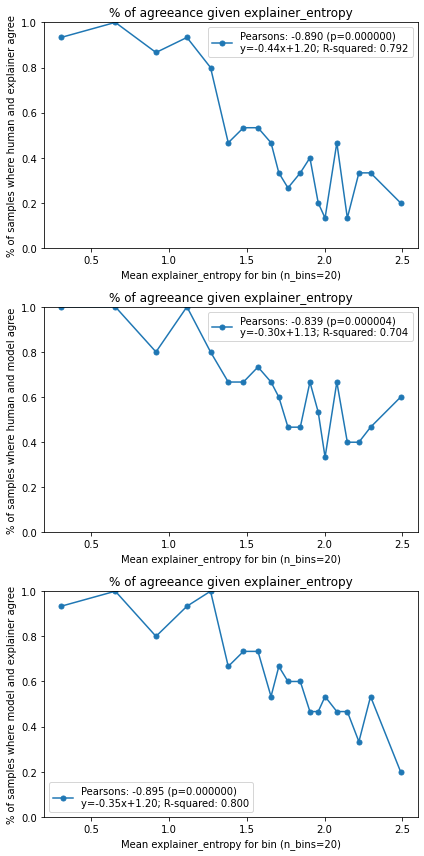

hi


<Figure size 432x288 with 0 Axes>

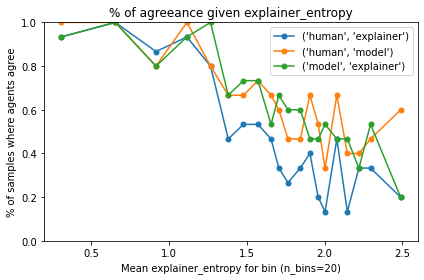

In [434]:
iv_names = ['explainer_entropy', 'explainer_scaled_t2c']
n_bins = 20
save_graph_dir = os.path.join(graph_dir, 'explainer_confusion')
ensure_dir(save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir,
    save_separate=False)

Pearson's linear correlation coefficient: -0.936 (p=0.000000
Line of best fit: y=-1.05x+1.32; R-squared: 0.876 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

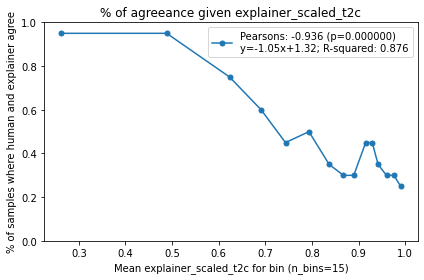

Pearson's linear correlation coefficient: -0.794 (p=0.000404
Line of best fit: y=-0.63x+1.15; R-squared: 0.631 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

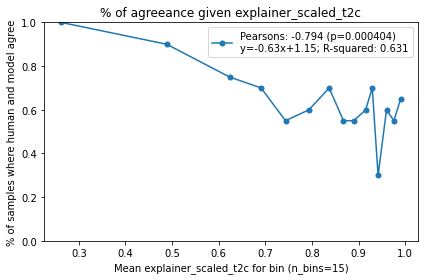

Pearson's linear correlation coefficient: -0.859 (p=0.000041
Line of best fit: y=-0.97x+1.40; R-squared: 0.738 p-val: 0.000
hi


<Figure size 432x288 with 0 Axes>

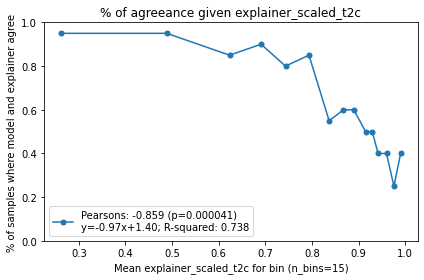

hi


<Figure size 432x288 with 0 Axes>

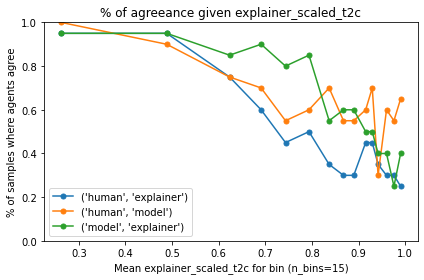

Pearson's linear correlation coefficient: -0.936 (p=0.000000
Line of best fit: y=-1.05x+1.32; R-squared: 0.876 p-val: 0.000
hi
% of samples where human and explainer agree
Pearson's linear correlation coefficient: -0.794 (p=0.000404
Line of best fit: y=-0.63x+1.15; R-squared: 0.631 p-val: 0.000
hi
% of samples where human and model agree
Pearson's linear correlation coefficient: -0.859 (p=0.000041
Line of best fit: y=-0.97x+1.40; R-squared: 0.738 p-val: 0.000
hi
% of samples where model and explainer agree


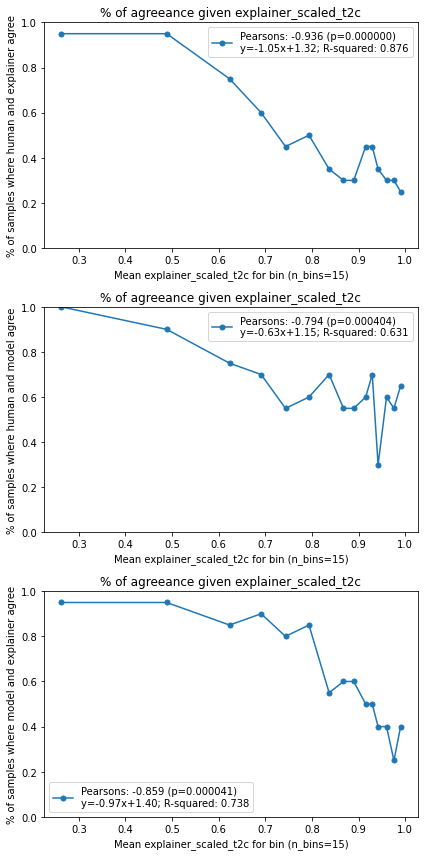

hi


<Figure size 432x288 with 0 Axes>

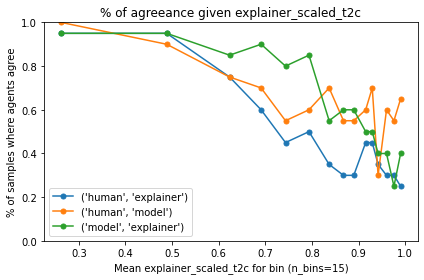

In [435]:
iv_names = ['explainer_scaled_t2c', 'explainer_entropy']
n_bins = 15
save_graph_dir = os.path.join(graph_dir, 'explainer_confusion')
ensure_dir(save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir)

plot_agreement(
    df=df, 
    iv_names=iv_names, 
    n_bins=n_bins, 
    save_graph_dir=save_graph_dir,
    save_separate=False)

### RQ: For each alignment pair, which confusion metric best predicts it?

Group by alignment

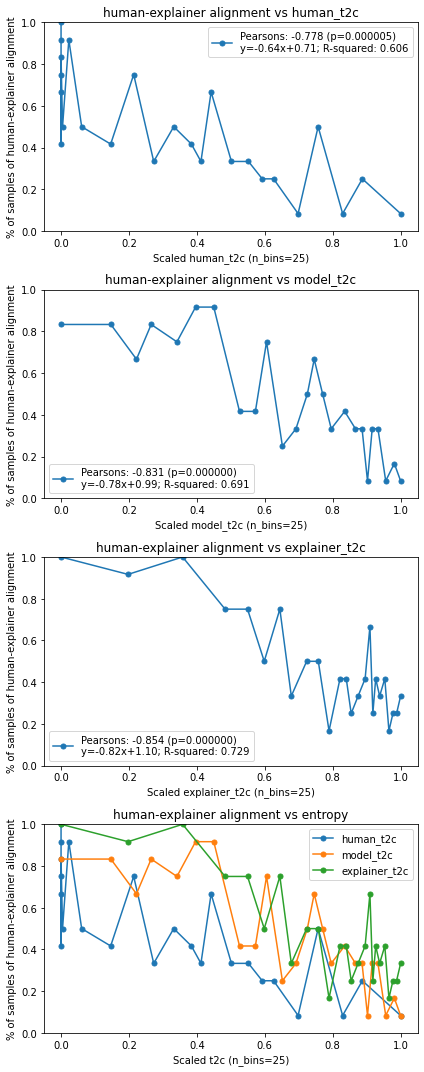

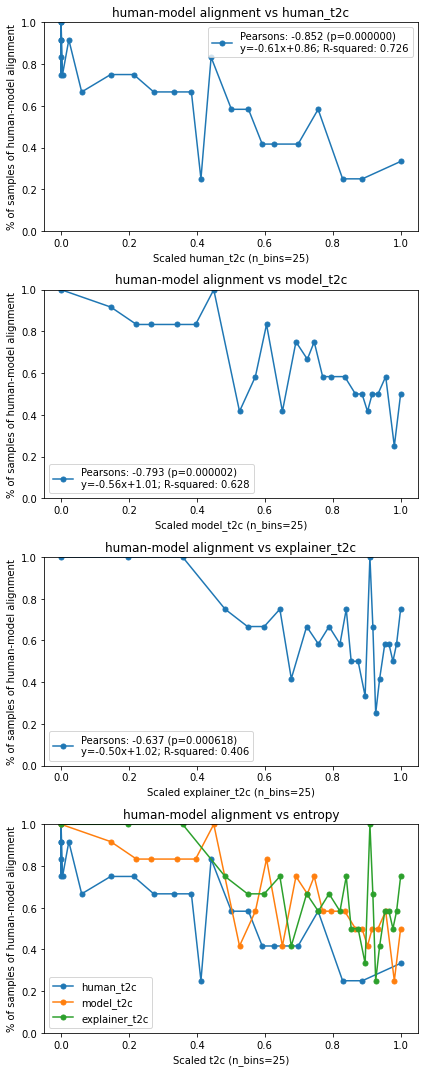

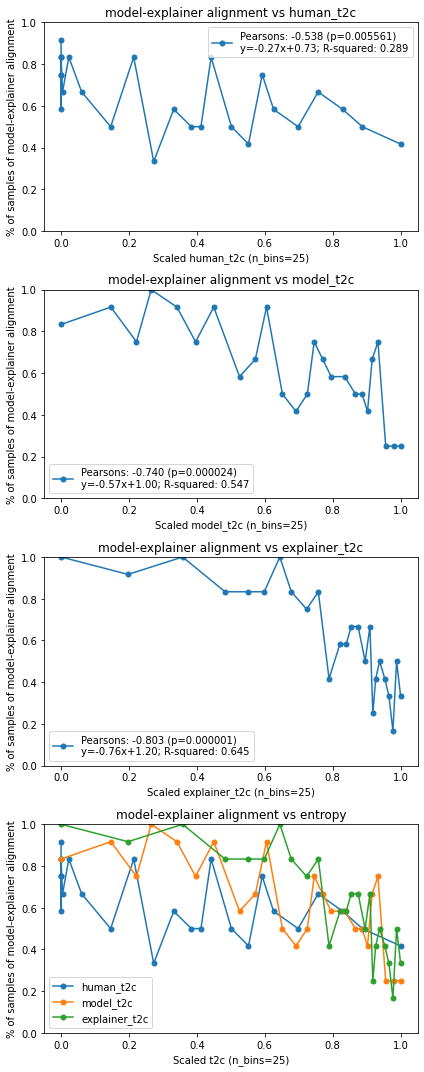

In [98]:
graph_save_dir = os.path.join(os.path.dirname(csv_path), 'graphs', 'iv_confusion_dv_alignment')
ensure_dir(graph_save_dir)

agent_pairs = [
    ('human', 'explainer'),
    ('human', 'model'),
    ('model', 'explainer')]
agents = ['human', 'model', 'explainer']
n_bins = 25
# confusion_templates = ['{}_entropy', '{}_t2c']
confusion_templates = ['{}_t2c', '{}_entropy']
for agent_pair in agent_pairs:
    agent1, agent2 = agent_pair
    confusions = []
    agreements = []
    fig, axs = plt.subplots(4, 1, figsize=(6, 15))
    
    ylabel = '% of samples of {}-{} alignment'.format(agent1, agent2)
    # Separate plot for each
    for idx, agent in enumerate(agents):
        confusion_names = [confusion_template.format(agent) for confusion_template in confusion_templates]
        xlabel = 'Scaled {} (n_bins={})'.format(confusion_names[0], n_bins)
        bin_rows, iv_means = sort_and_bin_df(
            df=df,
            sort_columns=confusion_names, 
            n_bins=n_bins)
        min_iv = np.amin(iv_means)
        max_iv = np.amax(iv_means)
        iv_means = (iv_means - min_iv) / (max_iv - min_iv)
        
        cur_agreement = calculate_bin_agreement(
                bin_rows=bin_rows,
                agent1=agent1,
                agent2=agent2)
        confusions.append(iv_means)
        agreements.append(cur_agreement)
        
        pearsons = stats.pearsonr(
            x=iv_means,
            y=cur_agreement)
        slope, yint, r, p, std_err = stats.linregress(iv_means, cur_agreement)
        r_squared = r ** 2
        fig, ax = plot(
            xs=[iv_means],
            ys=[cur_agreement],
            fig=fig,
            ax=axs[idx],
            xlabel=xlabel,
            ylabel=ylabel,
            ylimits=[0, 1],
            labels=['Pearsons: {:.3f} (p={:.6f})\ny={:.2f}x+{:.2f}; R-squared: {:.3f}'.format(
                pearsons.statistic, pearsons.pvalue, slope, yint, r_squared)],
            title='{}-{} alignment vs {}'.format(agent1, agent2, confusion_names[0]),
            show=False)
        axs[idx] = ax
    
    xlabel = 'Scaled {} (n_bins={})'.format(confusion_templates[0].split('_')[1], n_bins)
    title = '{}-{} alignment vs entropy'.format(agent1, agent2)
    fig, ax = plot(
        xs=confusions,
        ys=agreements,
        fig=fig,
        ax=axs[-1],
        labels=[confusion_templates[0].format(agent) for agent in agents],
        xlabel=xlabel,
        ylabel=ylabel,
        ylimits=[0, 1],
        title=title,
        show=False)
    axs[-1] = ax
    plt.savefig(os.path.join(graph_save_dir, '{}-{}_alignment_v_{}.png'.format(agent1, agent2, confusion_templates[0].split('_')[1])))
    plt.show()

### Calculate correlations between different confusions

In [443]:
confusion_names = ['human_entropy', 'human_t2c',
                   'model_entropy', 'model_t2c',
                   'explainer_entropy', 'explainer_t2c']
for i, confusion_i in enumerate(confusion_names[:-1]):
    for j, confusion_j in enumerate(confusion_names[i+1:]):
        print(confusion_i, confusion_j)
        x = df[confusion_i].to_numpy()
        y = df[confusion_j].to_numpy()
        pearsons = stats.pearsonr(
            x=x,
            y=y)

        print("pearsons: {:.3f}".format(pearsons.statistic))

entropy unnormalized_top_2_confusion
pearsons: 0.846
entropy model_entropy
pearsons: 0.297
entropy model_t2c
pearsons: 0.273
entropy explainer_entropy
pearsons: 0.311
entropy explainer_t2c
pearsons: 0.296
unnormalized_top_2_confusion model_entropy
pearsons: 0.303
unnormalized_top_2_confusion model_t2c
pearsons: 0.294
unnormalized_top_2_confusion explainer_entropy
pearsons: 0.353
unnormalized_top_2_confusion explainer_t2c
pearsons: 0.342
model_entropy model_t2c
pearsons: 0.889
model_entropy explainer_entropy
pearsons: 0.509
model_entropy explainer_t2c
pearsons: 0.471
model_t2c explainer_entropy
pearsons: 0.430
model_t2c explainer_t2c
pearsons: 0.465
explainer_entropy explainer_t2c
pearsons: 0.843


### Sensitivity study of number of bins on Pearson's and R-Squared of all three alignments 

Group by confusion

Does the number of bins ever swap ranking of which alignment is better predicted by the metric?

n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

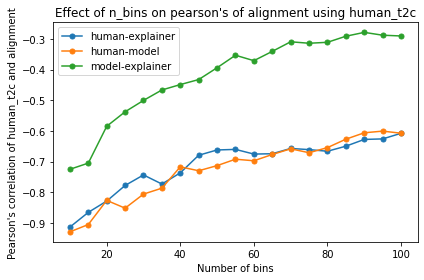

<Figure size 432x288 with 0 Axes>

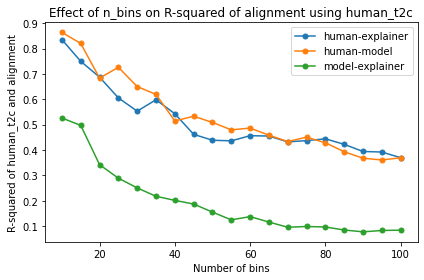

n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

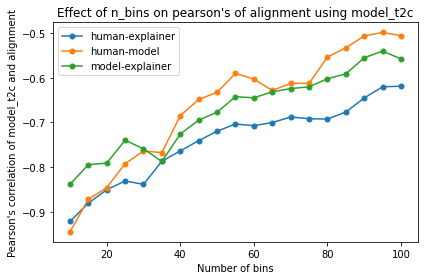

<Figure size 432x288 with 0 Axes>

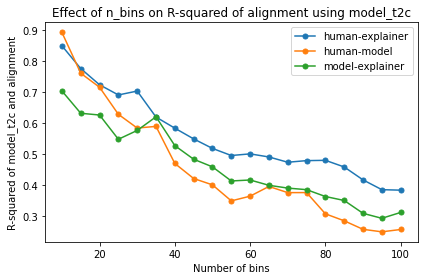

n_bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]


<Figure size 432x288 with 0 Axes>

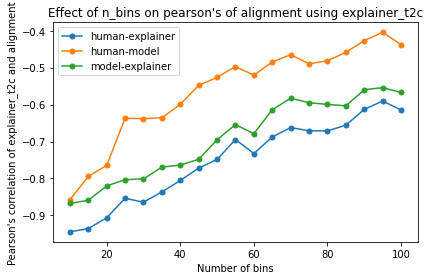

<Figure size 432x288 with 0 Axes>

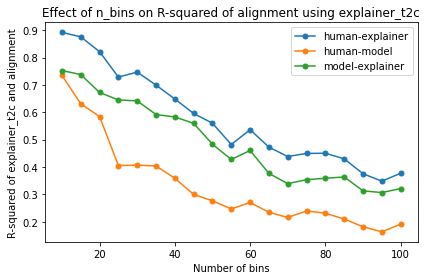

In [100]:
graph_save_dir = os.path.join(os.path.dirname(csv_path), 'graphs', 'n_bin_sensitivity')
ensure_dir(graph_save_dir)

for iv_agent in ['human', 'model', 'explainer']:
    # iv_names = ['{}_entropy'.format(iv_agent), 
    #             '{}_t2c'.format(iv_agent)]
    iv_names = ['{}_t2c'.format(iv_agent),
                '{}_entropy'.format(iv_agent)]
    agent_pairs = [
        ('human', 'explainer'),
        ('human', 'model'),
        ('model', 'explainer')]
    all_pearsons = []
    all_r_squared = []
    n_bins = [i for i in range(10, 101, 5)]
    print("n_bins: {}".format(n_bins))

    for pair_idx, pair in enumerate(agent_pairs):
        agent1, agent2 = pair
        cur_pearsons = []
        cur_r_squared = []
        for n_bin in n_bins:
            bin_rows, iv_means = sort_and_bin_df(
                df=df,
                sort_columns=iv_names, 
                n_bins=n_bin)
            cur_agreement = calculate_bin_agreement(
                bin_rows=bin_rows,
                agent1=agent1,
                agent2=agent2)
            pearsons = stats.pearsonr(iv_means, cur_agreement).statistic
            cur_pearsons.append(pearsons)
            # slope, yint, r, p, std_err = stats.linregress(iv_means, cur_agreement)
            r_squared = pearsons ** 2
            cur_r_squared.append(r_squared)
        all_pearsons.append(cur_pearsons)
        all_r_squared.append(cur_r_squared)

    # Plot pearsons v n_bins
    plot(
        xs=[n_bins for i in range(3)],
        ys=all_pearsons,
        labels=['{}-{}'.format(pair[0], pair[1]) for pair in agent_pairs],
        xlabel='Number of bins',
        ylabel="Pearson's correlation of {} and alignment".format(iv_names[0]),
        title='Effect of n_bins on pearson\'s of alignment using {}'.format(
            iv_names[0]),
        show=True,
        save_path=os.path.join(graph_save_dir, 'nbins_pearsons_{}.png'.format(iv_names[0])))


    # Plot r-squared v n_bins
    plot(
        xs=[n_bins for i in range(3)],
        ys=all_r_squared,
        labels=['{}-{}'.format(pair[0], pair[1]) for pair in agent_pairs],
        xlabel='Number of bins',
        ylabel="R-squared of {} and alignment".format(iv_names[0]),
        title='Effect of n_bins on R-squared of alignment using {}'.format(
            iv_names[0]),
        show=True,
        save_path=os.path.join(graph_save_dir, 'nbins_rsquared_{}.png'.format(iv_names[0])))

### Sensitivity study of number of bins on Pearson's and R-Squared of all three entropy types

Group by alignment measurement

Does the number of bins ever swap ranking of which confusion better predicts an alignment?

<Figure size 432x288 with 0 Axes>

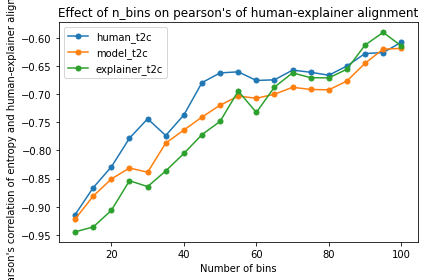

<Figure size 432x288 with 0 Axes>

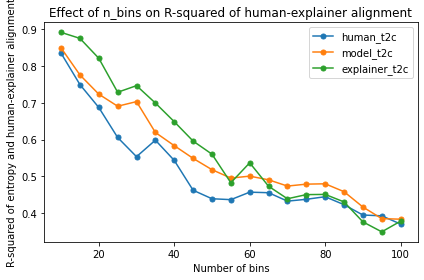

<Figure size 432x288 with 0 Axes>

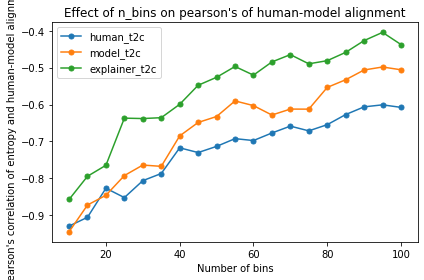

<Figure size 432x288 with 0 Axes>

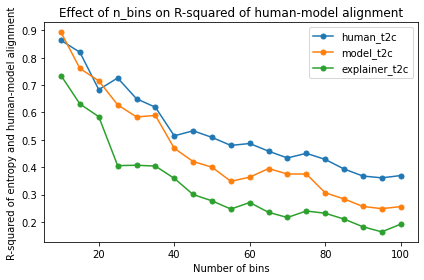

<Figure size 432x288 with 0 Axes>

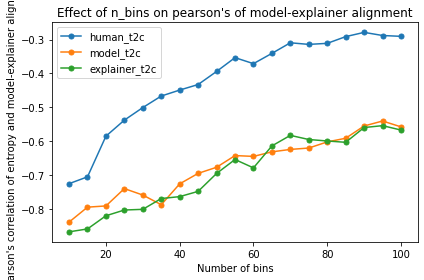

<Figure size 432x288 with 0 Axes>

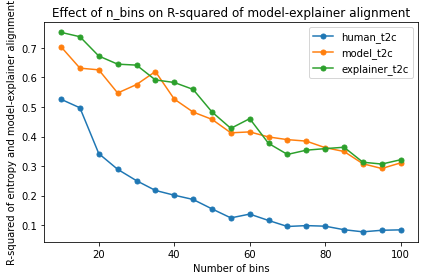

In [92]:
graph_save_dir = os.path.join(os.path.dirname(csv_path), 'graphs', 'n_bin_sensitivity')
ensure_dir(graph_save_dir)
agent_pairs = [
        ('human', 'explainer'),
        ('human', 'model'),
        ('model', 'explainer')]
agents = ['human', 'model', 'explainer']
n_bins = [i for i in range(10, 101, 5)]
# iv_name_templates = ['{}_entropy', '{}_t2c']
iv_name_templates = ['{}_t2c', '{}_entropy']

for pair_idx, pair in enumerate(agent_pairs):
    agent1, agent2 = pair
    all_pearsons = []
    all_r_squared = []

    for iv_agent in agents:
        iv_names = [template.format(iv_agent) for template in iv_name_templates]
        
        cur_pearsons = []
        cur_r_squared = []
        for n_bin in n_bins:
            bin_rows, iv_means = sort_and_bin_df(
                df=df,
                sort_columns=iv_names, 
                n_bins=n_bin)
            cur_agreement = calculate_bin_agreement(
                bin_rows=bin_rows,
                agent1=agent1,
                agent2=agent2)
            pearsons = stats.pearsonr(iv_means, cur_agreement).statistic
            cur_pearsons.append(pearsons)
            # slope, yint, r, p, std_err = stats.linregress(iv_means, cur_agreement)
            r_squared = pearsons ** 2
            cur_r_squared.append(r_squared)
        all_pearsons.append(cur_pearsons)
        all_r_squared.append(cur_r_squared)

    # Plot pearsons v n_bins
    plot(
        xs=[n_bins for i in range(3)],
        ys=all_pearsons,
        labels=[iv_name_templates[0].format(agent) for agent in agents],
        xlabel='Number of bins',
        ylabel="Pearson's correlation of entropy and {}-{} alignment".format(agent1, agent2),
        title='Effect of n_bins on pearson\'s of {}-{} alignment'.format(
            agent1, agent2),
        show=True,
        save_path=os.path.join(graph_save_dir, 'nbins_pearsons_{}-{}_{}.png'.format(
            agent1, agent2, iv_name_templates[0].split("_")[1])))


    # Plot r-squared v n_bins
    plot(
        xs=[n_bins for i in range(3)],
        ys=all_r_squared,
        labels=[iv_name_templates[0].format(agent) for agent in agents],
        xlabel='Number of bins',
        ylabel="R-squared of entropy and {}-{} alignment".format(agent1, agent2),
        title='Effect of n_bins on R-squared of {}-{} alignment'.format(agent1, agent2),
        show=True,
        save_path=os.path.join(graph_save_dir, 'nbins_rsquared_{}-{}_{}.png'.format(
            agent1, agent2, iv_name_templates[0].split("_")[1])))

## Side Quest Experiment: Does model-explainer alignment predict failure modes better than model confidence?

## 5-way Separation + 2 way separation (congruent/incongruent)

### 5 way separation by these categories
1. Model = Explainer = Human
2. Model = Explainer != Human
3. Model = Human != Explainer
4. Explainer = Human ! = Model
5. Model != Explainer != Human

In [4]:
csv_path = 'saved/ADE20K/survey_results/processed_results_300_samples.csv'
groups_save_dir = os.path.join(os.path.dirname(csv_path), 'group_csvs')
ensure_dir(groups_save_dir)

n_groups = 5
save_csvs = False
for i in range(1, n_groups+1):
    group_csv_path = os.path.join(groups_save_dir, 'group_{}.csv'.format(i))
    if not os.path.exists(group_csv_path):
        save_csvs = True
        break
        
dfs = []
if save_csvs:
    # Case 1: model = explainer = human 
    df1 = df[(df['model_predictions'] == df['explainer_predictions']) & (df['model_predictions'] == df['human_predictions'])]
    dfs.append(df1)
    # Case 2: model = explainer != human
    df2 = df[(df['model_predictions'] == df['explainer_predictions']) & (df['model_predictions'] != df['human_predictions'])]
    dfs.append(df2)

    # Case 3: model = human != explainer
    df3 = df[(df['model_predictions'] == df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions'])]
    dfs.append(df3)

    # Case 4: explainer = human != model
    df4 = df[(df['explainer_predictions'] == df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions'])]
    dfs.append(df4)

    # Case 5: explainer != model != human
    df5 = df[(df['explainer_predictions'] != df['human_predictions']) & (df['model_predictions'] != df['explainer_predictions']) & (df['model_predictions'] != df['human_predictions'])]
    dfs.append(df5)

    # Check that no rows overlap, all mutually exclusive
    for i in range(len(dfs) - 1):
        for j in range(i+1, len(dfs)):
            overlap = set(dfs[i]['filename']) & set(dfs[j]['filename'])
            assert len(overlap) == 0
    for idx, cur_df in enumerate(dfs):
        cur_csv_save_path = os.path.join(groups_save_dir, 'group_{}.csv'.format(idx+1))
        cur_df.to_csv(cur_csv_save_path)
        print("Saved CSV for group {} to {}".format(idx+1, cur_csv_save_path))

else: # CSVs already exist, load them
    for i in range(1, n_groups+1):
        group_csv_path = os.path.join(groups_save_dir, 'group_{}.csv'.format(i))
        dfs.append(pd.read_csv(group_csv_path))
        print("Loaded csv for group {} from {}".format(i, group_csv_path))



Loaded csv for group 1 from saved/ADE20K/survey_results/group_csvs/group_1.csv
Loaded csv for group 2 from saved/ADE20K/survey_results/group_csvs/group_2.csv
Loaded csv for group 3 from saved/ADE20K/survey_results/group_csvs/group_3.csv
Loaded csv for group 4 from saved/ADE20K/survey_results/group_csvs/group_4.csv
Loaded csv for group 5 from saved/ADE20K/survey_results/group_csvs/group_5.csv


In [5]:
for idx, cur_df in enumerate(dfs):
    print("Case {} has {} rows".format(idx+1, len(cur_df)))
    mean_entropy = cur_df['human_entropy'].mean()
    std_entropy = cur_df['human_entropy'].std()
    
    mean_t2c = cur_df['human_t2c'].mean()
    std_t2c = cur_df['human_t2c'].std()
    print("\tEntropy: {:.3f} ({:.3f})".format(mean_entropy, std_entropy))
    print("\tT2C: {:.3f} ({:.3f})".format(mean_t2c, std_t2c))
    
    

Case 1 has 132 rows
	Entropy: 0.201 (0.289)
	T2C: 0.193 (0.252)
Case 2 has 58 rows
	Entropy: 0.560 (0.350)
	T2C: 0.516 (0.281)
Case 3 has 62 rows
	Entropy: 0.315 (0.309)
	T2C: 0.335 (0.285)
Case 4 has 13 rows
	Entropy: 0.272 (0.313)
	T2C: 0.312 (0.252)
Case 5 has 35 rows
	Entropy: 0.616 (0.405)
	T2C: 0.544 (0.291)


#### Calculate statistical significance of entropy and T2C between Case 1 and all 4 other cases

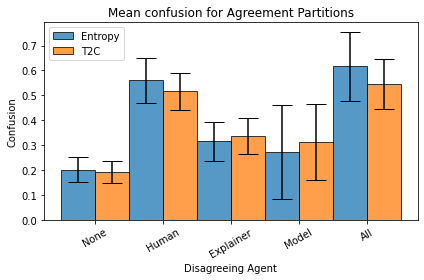

In [51]:
graph_data = {}
for metric in ['human_entropy', 'human_t2c']:
    means = []
    stds = []
    sems = []
    pvalues = []
    tstats = []
    cis = []
    for idx in range(5):
        cur_df = dfs[idx]
        means.append(cur_df[metric].mean())
        stds.append(cur_df[metric].std())
        sems.append(stats.sem(cur_df[metric]))
        
        if idx > 0:
            base = dfs[0][metric]
            comparison = cur_df[metric]
            
            ttest = stats.ttest_ind(
                base,
                comparison,
                equal_var=False,
                alternative='less'
            )
            pvalues.append(ttest.pvalue)
            tstats.append(ttest.statistic)
        else:
            pvalues.append(-1)
            tstats.append(None)

        confidence_interval = stats.norm.interval(
            confidence=0.95,
            # df=len(cur_df)-1,
            loc=cur_df[metric].mean(),
            scale=stats.sem(cur_df[metric]))
        tconfidence_interval = stats.t.interval(
            confidence=0.95,
            df=len(cur_df)-1,
            loc=cur_df[metric].mean(),
            scale=stats.sem(cur_df[metric]))
        cis.append((tconfidence_interval[1] - tconfidence_interval[0]) / 2)

            
    graph_data[metric] = {
        'means': np.array(means),
        'stds': np.array(stds),
        'sems': np.array(sems),
        'pvalues': np.array(pvalues),
        'cis': np.array(cis)
    }
    

bar_graph_save_path = os.path.join(
    'saved/ADE20K/survey_results/graphs', 'confusion_across_groups.png')
bar_graph(
    data=np.stack([graph_data['human_entropy']['means'], graph_data['human_t2c']['means']], axis=0),
    errors=np.stack([graph_data['human_entropy']['cis'], graph_data['human_t2c']['cis']], axis=0),
    labels=['None', 'Human', 'Explainer', 'Model', 'All'],
    groups=['human_entropy', 'T2C'],
    xlabel='Disagreeing Agent',
    ylabel='Confusion',
    xlabel_rotation=30,
    title='Mean confusion for Agreement Partitions',
    save_path=bar_graph_save_path
)


In [55]:
# Perform t-test on cases 2 and 5
for metric in ['human_entropy', 'human_t2c']:
    ttest = stats.ttest_ind(
        dfs[1][metric],
        dfs[4][metric],
        equal_var=True,
        alternative='two-sided'
    )
    print(ttest)

Ttest_indResult(statistic=-0.709657269706876, pvalue=0.47973114773802905)
Ttest_indResult(statistic=-0.4619386236447016, pvalue=0.6452277995272067)


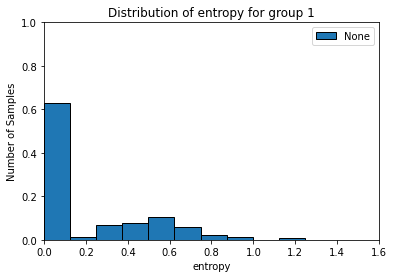

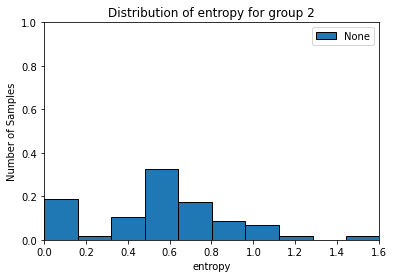

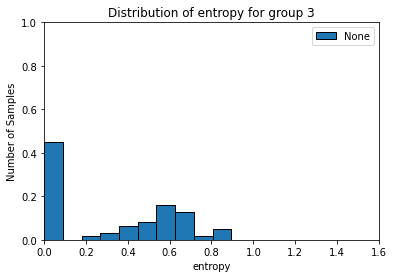

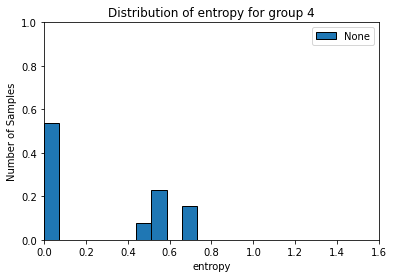

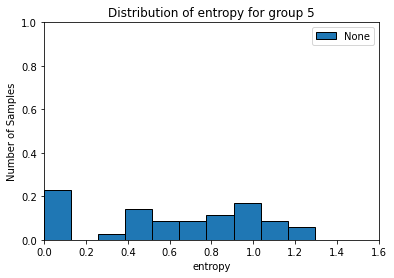

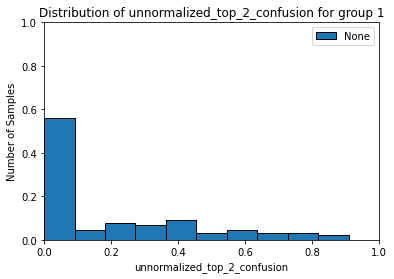

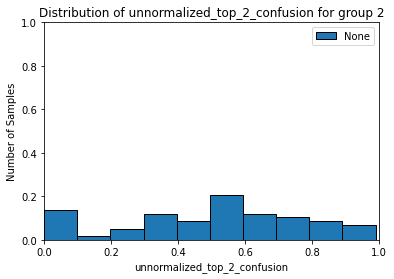

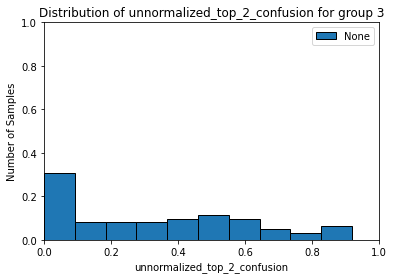

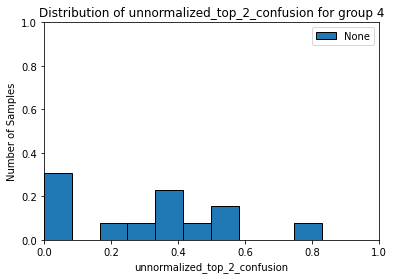

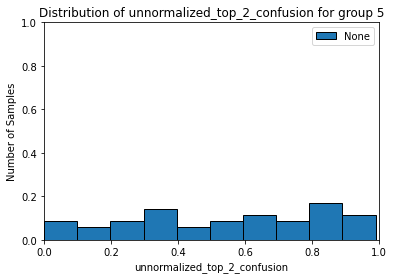

<Figure size 432x288 with 0 Axes>

In [21]:
# Create histograms for all groups to show distribution of confusion
graph_save_dir = os.path.join(os.path.dirname(csv_path), 'graphs')
ensure_dir(graph_save_dir)
for confusion_metric in ['human_entropy', 'human_t2c']:
    for idx, cur_df in enumerate(dfs):
        data = [cur_df[confusion_metric].to_numpy()]
        graph_save_path = os.path.join(graph_save_dir, '{}_group{}.png'.format(
            confusion_metric, idx+1))
        
        histogram(
            data=data,
            weights=[np.ones_like(cur_data) / len(cur_data) for cur_data in data],
            title="Distribution of {} for group {}".format(confusion_metric, idx+1),
            xlabel=confusion_metric,
            ylabel="Number of Samples",
            xlim=(0, 1.6) if confusion_metric == 'human_entropy' else (0, 1.0),
            ylim=(0, 1),
            show=True,
            save_path=graph_save_path
        )
        

In [23]:
# Are groups 3,4 statistically significant from one another?
for metric in ['human_entropy', 'human_t2c']:
    group_3 = dfs[2][metric]
    group_4 = dfs[3][metric]
    ttest = stats.ttest_ind(
        group_3,
        group_4,
        equal_var=False
    )
    print("P value for {}: {}".format(metric, ttest.pvalue))

P value for entropy: 0.6580993869628459
P value for unnormalized_top_2_confusion: 0.7796251362210062


#### How many of wrong predictions (of model or explainer) are the second human choice?

In [63]:
def rank_odd_one_out(cur_df, 
                     ooo_name,
                     include_out_of_bounds=False):
    # cur_df = dfs[idx]
    n_samples = len(cur_df)
    # Convert human probabilities from str -> numpy
    if type(cur_df['human_probabilities'][0]) == str:
        cur_df = convert_string_columns(cur_df, columns=['human_probabilities'])
    human_probabilities = np.stack(cur_df['human_probabilities'].to_numpy(), axis=0)
    n_classes = human_probabilities.shape[-1]
    
    # Obtain predictions
    human_predictions = np.argmax(human_probabilities, axis=1)
    model_predictions = cur_df['model_predictions'].to_numpy()
    explainer_predictions = cur_df['explainer_predictions'].to_numpy()
    # Sanity check
    if ooo_name == 'both':
        # assert (model_predictions == explainer_predictions).all()
        assert not (model_predictions == human_predictions).any()
        assert not (explainer_predictions == human_predictions).any()
        ooo_predictions = model_predictions
    elif ooo_name == 'model':
        # assert (explainer_predictions == human_predictions).all()
        assert not (model_predictions == human_predictions).any()
        ooo_predictions = model_predictions
    elif ooo_name == 'explainer':
        # assert (model_predictions == human_predictions).all()
        assert not (explainer_predictions == human_predictions).any()
        ooo_predictions = explainer_predictions
    else:
        raise ValueError("{} not supported".format(ooo_name))
    sort_idxs = np.argsort(-human_probabilities, axis=1)
    # Count number of rows where only non-zero in human annotations is the top prediction
    mask = np.where(human_probabilities > 0, 1, 0)
    count_nonzero_labels = np.sum(mask, axis=1)  # N x 1 array of how many non-zero labels in each human soft label
    ranks = []
    out_of_bounds_mask = []
    for idx in range(n_samples):
        cur_count_nonzero_labels = count_nonzero_labels[idx]
        cur_argsort = sort_idxs[idx]
        cur_prediction = ooo_predictions[idx]
        prediction_rank = np.where(cur_argsort == cur_prediction)[0][0]
        # This means it is one of the 0's in the human probability distribution
        if prediction_rank >= cur_count_nonzero_labels:
            ranks.append((cur_count_nonzero_labels + n_classes - 1) / 2)
            out_of_bounds_mask.append(1)
            # if include_out_of_bounds:
            #     ranks.append()
            # else:
            #     ranks.append(-1)
            # print("soft label: {}".format(human_probabilities[idx]))
            # print("model prediction: {} rank {}".format(cur_prediction, prediction_rank))
            # print("cur count_nonzero_labels: {}".format(cur_count_nonzero_labels))
        else:
            ranks.append(prediction_rank)
            out_of_bounds_mask.append(0)
    ranks = pd.DataFrame({
        "rank": ranks,
        "out_of_bounds": out_of_bounds_mask,
        "n_nonzero_labels": count_nonzero_labels})
    
    n_out_of_rank = len(ranks[ranks['out_of_bounds'] == 1])
    # n_one_hot_out_of_rank = len(
    n_top_2 = len(ranks[(ranks['rank'] == 1) & (ranks['out_of_bounds'] == 0)])
    n_else = len(ranks[(ranks['rank'] > 1) & (ranks['out_of_bounds'] == 0)])
    # Average rank
    # filtered_ranks = ranks[ranks != -1]
    # # print(filtered_ranks)
    mean_rank = ranks['rank'].mean()
    std_rank = ranks['rank'].std()
    filtered_ranks = ranks[ranks['out_of_bounds'] == 0]
    mean_filtered_rank = filtered_ranks['rank'].mean()
    std_filtered_rank = filtered_ranks['rank'].std()
    
    
    temp = pd.concat([cur_df, ranks], axis=1)
    n_one_hot_out_of_rank = len(temp[(temp['out_of_bounds'] == 1) & (temp['n_nonzero_labels'] == 1)])
    n_two_hot_out_of_rank = len(temp[(temp['out_of_bounds'] == 1) & (temp['n_nonzero_labels'] == 2)])
    
    n_one_hot_top_2 = len(temp[(temp['out_of_bounds'] == 0) & (temp['rank'] == 1) & (temp['n_nonzero_labels'] == 1)])
    n_two_hot_top_2 = len(temp[(temp['out_of_bounds'] == 0) & (temp['rank'] == 1) * (temp['n_nonzero_labels'] == 2)])
    
    print("{}/{} {:.3f} samples have model prediction as 2nd top prediction".format(n_top_2, n_samples, n_top_2 / n_samples))
    print("{}/{} {:.3f} samples where model prediction is beyond top 2 but plausible".format(n_else, n_samples, n_else / n_samples))
    print("{}/{} {:.3f} samples the model and explainer predict something the humans are sure it is not".format(n_out_of_rank, n_samples, n_out_of_rank / n_samples))
    
    print("{}/{} {:.3f} non-plausibles have one hot human soft labels".format(
        n_one_hot_out_of_rank, n_out_of_rank, n_one_hot_out_of_rank / n_out_of_rank))
    print("{}/{} {:.3f} non-plausibles have two hot human soft labels".format(
        n_two_hot_out_of_rank, n_out_of_rank, n_two_hot_out_of_rank / n_out_of_rank))
    
    print("{}/{} {:.3f} top-2's have one hot human soft labels".format(
        n_one_hot_top_2, n_top_2, n_one_hot_top_2 / n_top_2))
    print("{}/{} {:.3f} top-2's have two hot human soft labels".format(
        n_two_hot_top_2, n_top_2, n_two_hot_top_2 / n_top_2))
    print("")
    print("Mean rank of all options is {:.3f} ({:.3f})".format(mean_rank, std_rank))
    print("Mean rank of plausible options is {:.3f} ({:.3f})".format(mean_filtered_rank, std_filtered_rank))
    rank_counts = {
        "n_out_of_rank": n_out_of_rank,
        "n_top_2": n_top_2,
        "n_else": n_else,
        "n_samples": n_samples,
        "mean_rank": mean_rank,
        "mean_filtered_rank": mean_filtered_rank,
        "count_nonzero_labels": count_nonzero_labels
    }
    return ranks, rank_counts



In [64]:
ooo_names = ['none', 'both', 'explainer', 'model', 'all']
rank_dfs = []
# Examining cases 2-4
for idx in range(1, 4):
    print("Case {}: {} is misaligned".format(idx+1, ooo_names[idx]))
    ranks, rank_counts = rank_odd_one_out(
        cur_df=dfs[idx],
        ooo_name=ooo_names[idx])
    rank_dfs.append(ranks)
    print("")
# Examine case 5: how does the disagreeance of the explainer and humans differ from model and humans?
cur_df = dfs[4]
print("Case 5a: both are misaligned; examining explainer differences")
explainer_ranks, explainer_rank_counts = rank_odd_one_out(
    cur_df=cur_df,
    ooo_name='explainer')
print("")
print("Case 5b: both are misaligned; examining model differences")
model_ranks, model_rank_counts = rank_odd_one_out(
    cur_df=cur_df,
    ooo_name='model')
print("")
rank_dfs.append(explainer_ranks)
rank_dfs.append(model_ranks)


Case 2: both is misaligned
27/58 0.466 samples have model prediction as 2nd top prediction
5/58 0.086 samples where model prediction is beyond top 2 but plausible
26/58 0.448 samples the model and explainer predict something the humans are sure it is not
11/26 0.423 non-plausibles have one hot human soft labels
12/26 0.462 non-plausibles have two hot human soft labels
0/27 0.000 top-2's have one hot human soft labels
22/27 0.815 top-2's have two hot human soft labels

Mean rank of all options is 4.388 (3.636)
Mean rank of plausible options is 1.156 (0.369)

Case 3: explainer is misaligned
16/62 0.258 samples have model prediction as 2nd top prediction
1/62 0.016 samples where model prediction is beyond top 2 but plausible
45/62 0.726 samples the model and explainer predict something the humans are sure it is not
28/45 0.622 non-plausibles have one hot human soft labels
16/45 0.356 non-plausibles have two hot human soft labels
0/16 0.000 top-2's have one hot human soft labels
13/16 0.81

In [101]:
# Calculate if there is any statistical significance of rank across any two groups
n_dfs = len(rank_dfs)
for i in range(n_dfs-1):
    for j in range(i+1, n_dfs):
        df_i = rank_dfs[i]
        df_j = rank_dfs[j]
        ranks_i = df_i['rank']
        ranks_j = df_j['rank']
        ttest = stats.ttest_ind(
            ranks_i,
            ranks_j,
            equal_var=False
        )
        print("Statistical test for all ranks i={}, j={}: {:.3f} (p={:.3f})".format(
            i, j, ttest.statistic, ttest.pvalue))
        filtered_ranks_i = df_i[df_i['out_of_bounds'] == 0]['rank']
        filtered_ranks_j = df_j[df_j['out_of_bounds'] == 0]['rank']
        ttest = stats.ttest_ind(
            filtered_ranks_i,
            filtered_ranks_j,
            equal_var=False
        )
        print("Statistical test for plausible ranks i={}, j={}: {:.3f} (p={:.3f})".format(
            i, j, ttest.statistic, ttest.pvalue))
        print("")

Statistical test for all ranks i=0, j=1: -2.948 (p=0.004)
Statistical test for plausible ranks i=0, j=1: 1.109 (p=0.273)

Statistical test for all ranks i=0, j=2: -1.445 (p=0.165)
Statistical test for plausible ranks i=0, j=2: 2.396 (p=0.023)

Statistical test for all ranks i=0, j=3: -2.074 (p=0.042)
Statistical test for plausible ranks i=0, j=3: 0.689 (p=0.497)

Statistical test for all ranks i=0, j=4: -2.605 (p=0.011)
Statistical test for plausible ranks i=0, j=4: -1.750 (p=0.103)

Statistical test for all ranks i=1, j=2: 0.309 (p=0.761)
Statistical test for plausible ranks i=1, j=2: 1.000 (p=0.332)

Statistical test for all ranks i=1, j=3: 0.328 (p=0.744)
Statistical test for plausible ranks i=1, j=3: -0.240 (p=0.812)

Statistical test for all ranks i=1, j=4: -0.123 (p=0.902)
Statistical test for plausible ranks i=1, j=4: -2.354 (p=0.035)

Statistical test for all ranks i=2, j=3: -0.068 (p=0.946)
Statistical test for plausible ranks i=2, j=3: -1.000 (p=0.339)

Statistical test for a

/tmp/ipykernel_503963/3858299452.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest = stats.ttest_ind(


#### Distribution of number of probable labels in each category

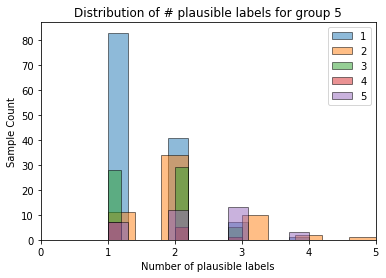

[0.49473684 0.39473684 0.08947368 0.01578947 0.00526316]
[0.38181818 0.41818182 0.17272727 0.02727273]
(190,) (110,)


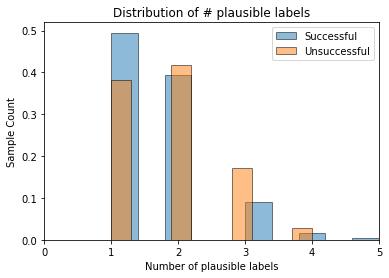

[(array([0.49473684, 0.        , 0.39473684, 0.        , 0.        ,
         0.08947368, 0.        , 0.01578947, 0.        , 0.00526316]),
  array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
  <BarContainer object of 10 artists>),
 (array([0.38181818, 0.        , 0.        , 0.41818182, 0.        ,
         0.        , 0.17272727, 0.        , 0.        , 0.02727273]),
  array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
  <BarContainer object of 10 artists>)]

<Figure size 432x288 with 0 Axes>

In [42]:

all_counts = []
for df_idx, cur_df in enumerate(dfs):
    # Obtain # of non-zero class labels for each sample from human probabilities
    if type(cur_df['human_probabilities'][0]) == str:
        cur_df = convert_string_columns(cur_df, columns=['human_probabilities'])
    human_probabilities = np.stack(cur_df['human_probabilities'].to_numpy(), axis=0)
    mask = np.where(human_probabilities > 0, 1, 0)
    count_nonzero_labels = np.sum(mask, axis=1)
    all_counts.append(count_nonzero_labels)
    
    # histogram(
    #     data=[count_nonzero_labels],
    #     xlabel='Number of plausible labels',
    #     ylabel='Sample Count',
    #     xlim=(0, 5),
    #     title='Distribution of # plausible labels for group {}'.format(df_idx+1))
        
histogram(
        data=all_counts,
        multi_method='overlap',
        weights=[None for i in range(5)],
        labels=[1, 2, 3, 4, 5],
        xlabel='Number of plausible labels',
        ylabel='Sample Count',
        xlim=(0, 5),
        alpha=0.5,
        title='Distribution of # plausible labels for group {}'.format(df_idx+1))

# Compare where model and explainer agree vs disagree
agree_counts = np.concatenate([all_counts[0], all_counts[1]], axis=0)
disagree_counts = np.concatenate([all_counts[2], all_counts[3], all_counts[4]], axis=0)
print(np.unique(agree_counts, return_counts=True)[1] / 190)
print(np.unique(disagree_counts, return_counts=True)[1] / 110)
print(agree_counts.shape, disagree_counts.shape)
data = [agree_counts, disagree_counts]

weights = [np.ones_like(cur_data) / len(cur_data) for cur_data in data]

histogram(
        data=data,
        multi_method='overlap',
        weights=weights,
        labels=['Successful', 'Unsuccessful'],
        xlabel='Number of plausible labels',
        ylabel='Sample Count',
        xlim=(0, 5),
        alpha=0.5,
        title='Distribution of # plausible labels',
        save_path='temp/plausible_labels_dist.png')

#### Calculate the class distribution across all 5 groups

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 Shopping and dining [INDOOR]
1 Workplace (office building, factory, lab, etc.) [INDOOR]
2 Home or hotel [INDOOR]
3 Transportation (vehicle interiors, stations, etc) [INDOOR]
4 Sports and leisure [INDOOR]
5 Cultural (art, education, religion, military, law, politics, etc) [INDOOR]
6 Water, ice, snow [OUTDOOR]
7 Mountains, hills, desert, sky [OUTDOOR]
8 Forest, field, jungle [OUTDOOR]
9 Man-made elements [OUTDOOR]
10 Transportation (roads, parking, bridges, boats, airports, etc) [OUTDOOR]
11 Cultural or historical building/places (military, religious) [OUTDOOR]
12 Sports fields, parks, leisure spaces [OUTDOOR]
13 Industrial and construction [OUTDOOR]
14 Houses, cabins, gardens, and farms [OUTDOOR]
15 Commercial buildings, shops, markets, cities, and towns [OUTDOOR]


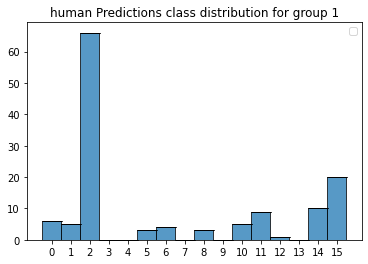

<Figure size 864x576 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


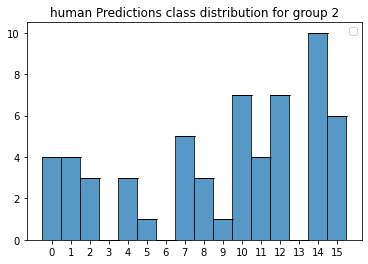

<Figure size 864x576 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


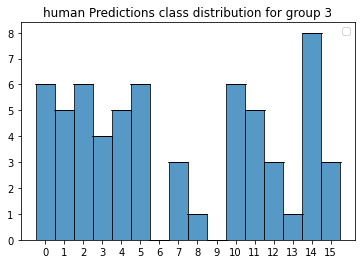

<Figure size 864x576 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


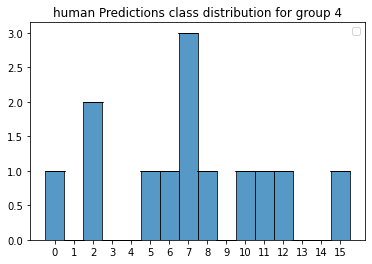

<Figure size 864x576 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


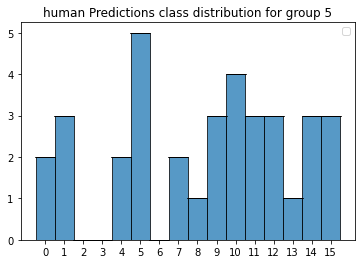

<Figure size 864x576 with 0 Axes>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


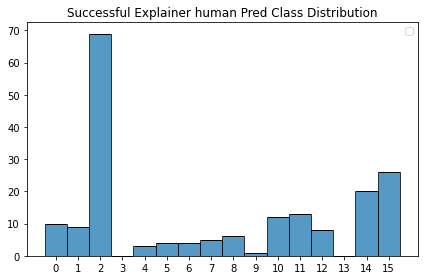

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


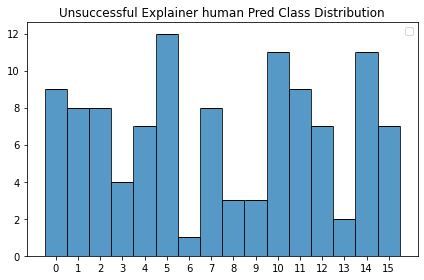

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(1, 16)


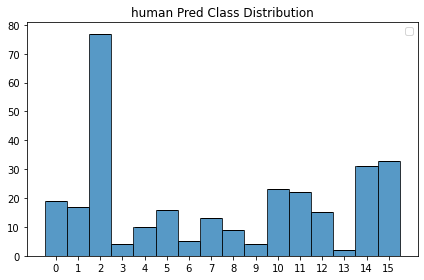

(5, 16)


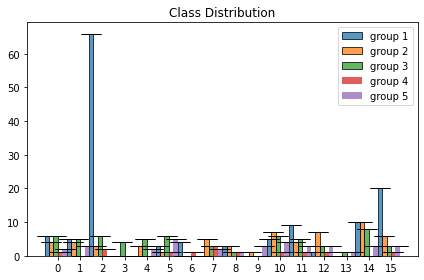

<Axes: title={'center': 'Class Distribution'}>

In [97]:
SCENE_CATEGORIES_PATH = os.path.join('data', 'ade20k', 'scene_categories.txt')
scene_categories = read_lists(SCENE_CATEGORIES_PATH)
for idx, cat in enumerate(scene_categories):
    print(idx, cat)
scene_cat = [cat.split(',')[0] for cat in scene_categories]

total_counts = []
agent = 'human'
for df_idx, cur_df in enumerate(dfs):
    human_predictions = cur_df['{}_predictions'.format(agent)].to_numpy()
    labels, counts = np.unique(human_predictions, return_counts=True)
    pred_counts_dict = {}
    for label, count in zip(labels, counts):
        pred_counts_dict[label] = count
    
    bar_graph_counts = []
    for category_idx, category in enumerate(scene_categories):
        if category_idx in pred_counts_dict:
            bar_graph_counts.append(pred_counts_dict[category_idx])
        else:
            bar_graph_counts.append(0)
    bar_graph_counts = np.array(bar_graph_counts)
    bar_graph_counts = np.expand_dims(bar_graph_counts, axis=0)
    total_counts.append(bar_graph_counts)
    bar_graph(
        data=bar_graph_counts,
        labels=[i for i in range(16)],
        # xlabel_rotation=45,
        fig_size=(12, 8),
        title='{} Predictions class distribution for group {}'.format(agent, df_idx+1),
        save_path='temp/{}_pred_group_{}.png'.format(agent, df_idx+1))

total_counts = np.concatenate(total_counts, axis=0)
# Split explainer success and failure
success_counts = np.sum(total_counts[:2], axis=0, keepdims=True)
fail_counts = np.sum(total_counts[2:], axis=0, keepdims=True)

bar_graph(
    data=success_counts,
    labels=[i for i in range(16)],
    title='Successful Explainer {} Pred Class Distribution'.format(agent),
    save_path='temp/succes.png')
bar_graph(
    data=fail_counts,
    labels=[i for i in range(16)],
    title='Unsuccessful Explainer {} Pred Class Distribution'.format(agent),
    save_path='temp/fail.png')
# Sum them all up
sum_total_counts = np.expand_dims(np.sum(total_counts, axis=0), axis=0)
print(sum_total_counts.shape)
bar_graph(
    data=sum_total_counts,
    labels=[i for i in range(16)],
    title='{} Pred Class Distribution'.format(agent),
    save_path='temp/class_dist.png')
print(total_counts.shape)
bar_graph(
    data=total_counts,
    groups=['group {}'.format(i) for i in range(1, 6)],
    labels=[i for i in range(16)],
    title='Class Distribution')

### Calculate entropy between congruent and incongruent samples and graph histograms

In [47]:
csv_path = os.path.join('saved', 'ADE20K', 'survey_results', 'processed_results_300_samples.csv')

df = pd.read_csv(csv_path)


In [48]:
congruent_df = df[df['congruent'] == 1]
incongruent_df = df[df['congruent'] == 0]
# assert len(congruent_df) == len(incongruent_df)
assert len(congruent_df) + len(incongruent_df) == len(df)

confusion_metrics = [
    'human_entropy', 
    'human_t2c',
    'kl_model_explainer'
]


In [49]:
# Calculate statistical significance 
for confusion_metric in confusion_metrics:
    congruent_values = congruent_df[confusion_metric].to_numpy()
    incongruent_values = incongruent_df[confusion_metric].to_numpy()
    mean_congruent_value = congruent_values.mean()
    std_congruent_value = congruent_values.std()
    mean_incongruent_value = incongruent_values.mean()
    std_incongruent_value = incongruent_values.std()
    
    print("{} congruent: {:.3f} ({:.3f})".format(confusion_metric, mean_congruent_value, std_congruent_value))
    print("{} incongruent: {:.3f} ({:.3f})".format(confusion_metric, mean_incongruent_value, std_incongruent_value))

    ttest = stats.ttest_ind(
        congruent_values,
        incongruent_values,
        equal_var=False
    )
    print("T-test for {} without equal variance: {} (p={})".format(confusion_metric, ttest.statistic, ttest.pvalue))

    ttest = stats.ttest_ind(
        congruent_values,
        incongruent_values,
        equal_var=True
    )
    print("T-test for {} with equal variance: {} (p={})".format(confusion_metric, ttest.statistic, ttest.pvalue))

entropy congruent: 0.310 (0.349)
entropy incongruent: 0.406 (0.368)
T-test for entropy without equal variance: -2.204395315968427 (p=0.02854375495713777)
T-test for entropy with equal variance: -2.236703312313414 (p=0.026045343876554165)
unnormalized_top_2_confusion congruent: 0.291 (0.299)
unnormalized_top_2_confusion incongruent: 0.399 (0.297)
T-test for unnormalized_top_2_confusion without equal variance: -2.9950083239592042 (p=0.003045958543890796)
T-test for unnormalized_top_2_confusion with equal variance: -2.989480379848614 (p=0.0030274053003198913)
kl_model_explainer congruent: 0.436 (0.496)
kl_model_explainer incongruent: 0.929 (0.670)
T-test for kl_model_explainer without equal variance: -6.6904260741380615 (p=2.771166189862776e-10)
T-test for kl_model_explainer with equal variance: -7.23958525716645 (p=3.8476811058620326e-12)


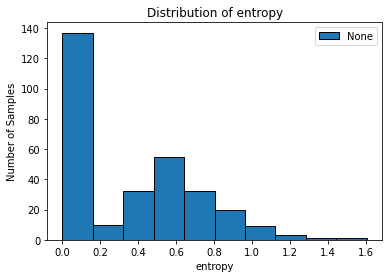

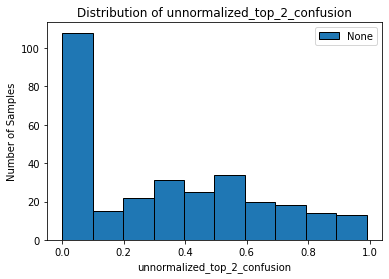

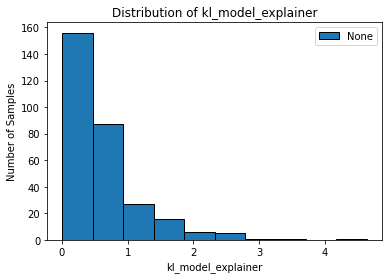

<Figure size 432x288 with 0 Axes>

In [50]:
# Histogram of all entropy values
for confusion_metric in confusion_metrics:
    histogram(
        data=[df[confusion_metric].to_numpy()],
        title="Distribution of {}".format(confusion_metric),
        xlabel=confusion_metric,
        ylabel="Number of Samples",
        show=True
    )

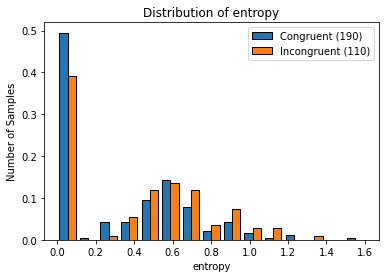

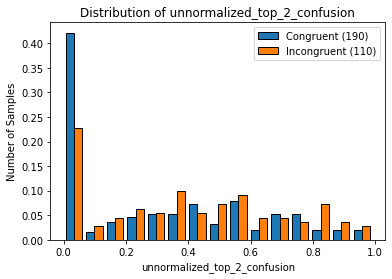

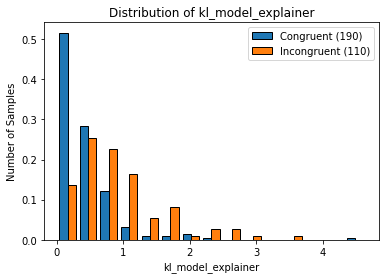

<Figure size 432x288 with 0 Axes>

In [51]:
# Separate plots for congruent vs incongruent
for confusion_metric in confusion_metrics:
    data = [congruent_df[confusion_metric].to_numpy(), incongruent_df[confusion_metric].to_numpy()]
    histogram(
        data=data,
        # weights=None,
        weights=[np.ones_like(cur_data) / len(cur_data) for cur_data in data],
        labels=["Congruent ({})".format(len(congruent_df)), "Incongruent ({})".format(len(incongruent_df))],
        n_bins=15,
        title="Distribution of {}".format(confusion_metric),
        xlabel=confusion_metric,
        ylabel="Number of Samples",
        show=True
    )


Entropy and KL Pearsons correlation: 0.113 (p=0.050)


<Figure size 432x288 with 0 Axes>

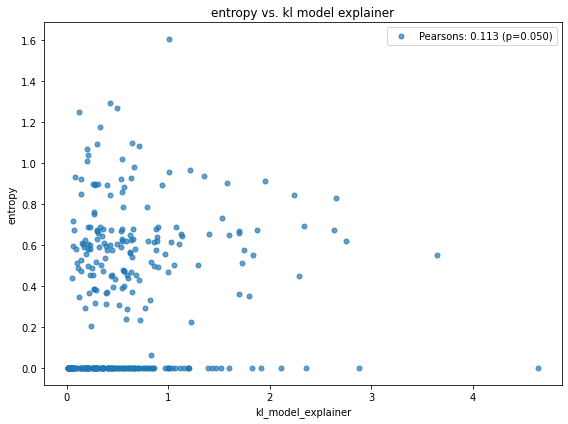

T2C and KL Pearsons correlation: 0.147 (p=0.011)


<Figure size 432x288 with 0 Axes>

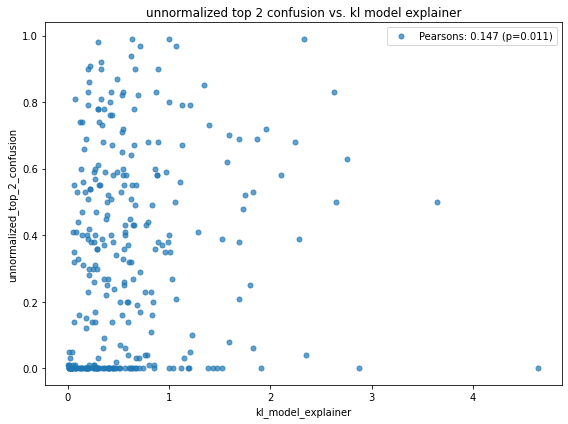

(<Figure size 576x432 with 1 Axes>,
 <Axes: title={'center': 'unnormalized top 2 confusion vs. kl model explainer'}, xlabel='kl_model_explainer', ylabel='unnormalized_top_2_confusion'>)

In [60]:
# Plot entropy vs top-2 confusion and color code by congruent or not
ylabel = 'human_entropy'
xlabel = 'kl_model_explainer'

entropy_pearsons = stats.pearsonr(df[xlabel], df[ylabel])
print("Entropy and KL Pearsons correlation: {:.3f} (p={:.3f})".format(
    entropy_pearsons.statistic,
    entropy_pearsons.pvalue))
plot(
    xs=[df[xlabel]],
    ys=[df[ylabel]],
    # labels=['Congruent', 'Incongruent'],
    labels=['Pearsons: {:.3f} (p={:.3f})'.format(entropy_pearsons.statistic, entropy_pearsons.pvalue)],
    marker_size=5,
    title='{} vs. {}'.format(ylabel.replace('_', ' '), xlabel.replace('_', ' ')),
    xlabel=xlabel,
    ylabel=ylabel,
    alpha=0.7,
    line=False,
    fig_size=(8,6),
    show=True
)

ylabel = 'human_t2c'
t2c_pearsons = stats.pearsonr(df[xlabel], df[ylabel])
print("T2C and KL Pearsons correlation: {:.3f} (p={:.3f})".format(
    t2c_pearsons.statistic,
    t2c_pearsons.pvalue))
plot(
    xs=[df[xlabel]],
    ys=[df[ylabel]],
    # labels=['Congruent', 'Incongruent'],
    labels=['Pearsons: {:.3f} (p={:.3f})'.format(t2c_pearsons.statistic, t2c_pearsons.pvalue)],
    marker_size=5,
    title='{} vs. {}'.format(ylabel.replace('_', ' '), xlabel.replace('_', ' ')),
    xlabel=xlabel,
    ylabel=ylabel,
    alpha=0.7,
    line=False,
    fig_size=(8,6),
    show=True
)

(<Figure size 576x432 with 1 Axes>,
 <Axes: title={'center': 'entropy vs. top 2 confusion'}, xlabel='top_2_confusion', ylabel='entropy'>)

<Figure size 432x288 with 0 Axes>

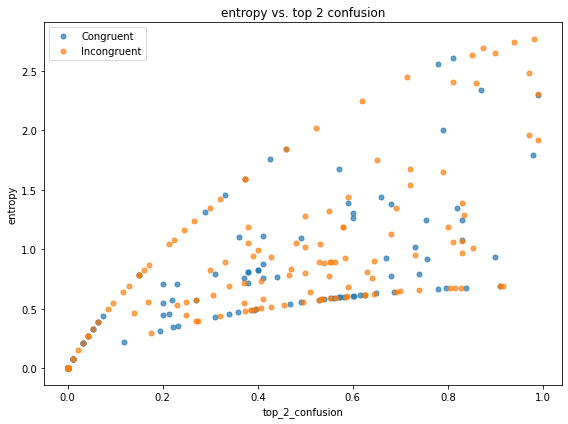

In [162]:
# Plot entropy vs top-2 confusion and color code by congruent or not
ylabel = 'human_entropy'
xlabel = 'top_2_confusion'

plot(
    xs=[congruent_df[xlabel], incongruent_df[xlabel]],
    ys=[congruent_df[ylabel], incongruent_df[ylabel]],
    labels=['Congruent', 'Incongruent'],
    marker_size=5,
    title='{} vs. {}'.format(ylabel.replace('_', ' '), xlabel.replace('_', ' ')),
    xlabel=xlabel,
    ylabel=ylabel,
    alpha=0.7,
    line=False,
    fig_size=(8,6)
)

<Figure size 432x288 with 0 Axes>

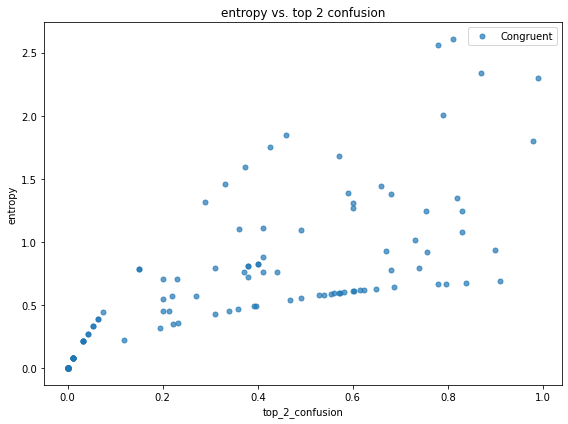

<Figure size 432x288 with 0 Axes>

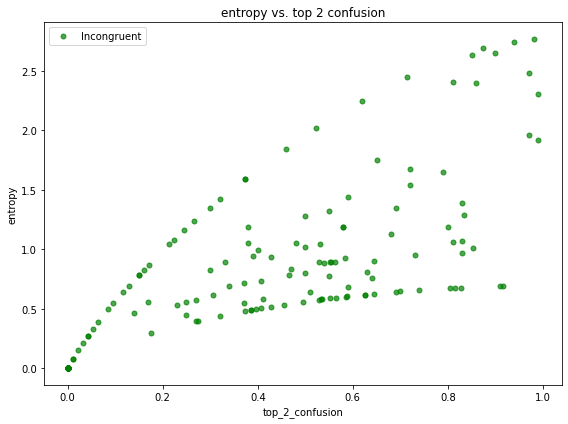

150 150


In [170]:
# Plot entropy vs top-2 confusion and color code by congruent or not
ylabel = 'human_entropy'
xlabel = 'top_2_confusion'
plot(
    xs=[congruent_df[xlabel]],
    ys=[congruent_df[ylabel]],
    labels=['Congruent'],
    marker_size=5,
    title='{} vs. {}'.format(ylabel.replace('_', ' '), xlabel.replace('_', ' ')),
    xlabel=xlabel,
    ylabel=ylabel,
    alpha=0.7,
    line=False,
    fig_size=(8,6),
    show=True
)

plot(
    xs=[incongruent_df[xlabel]],
    ys=[incongruent_df[ylabel]],
    labels=['Incongruent'],
    marker_size=5,
    title='{} vs. {}'.format(ylabel.replace('_', ' '), xlabel.replace('_', ' ')),
    xlabel=xlabel,
    ylabel=ylabel,
    alpha=0.7,
    line=False,
    fig_size=(8,6),
    colors=['g'],
    show=True
)

print(len(congruent_df), len(incongruent_df))


#### Visualize Examples of High and Low confusion for both congruent and incongruent samples

[0.0, 0.0, 0.0, 0.0, 0.0]


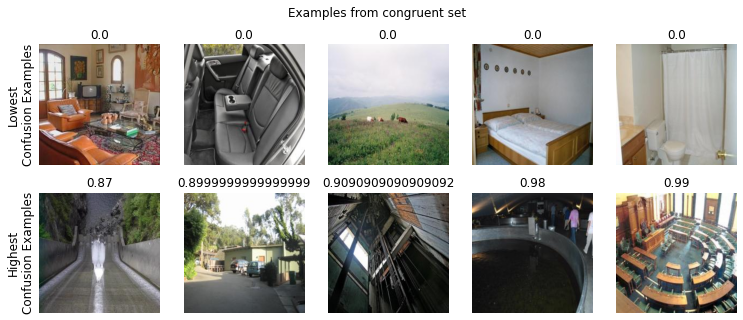

[0.0, 0.0, 0.0, 0.0, 0.0]


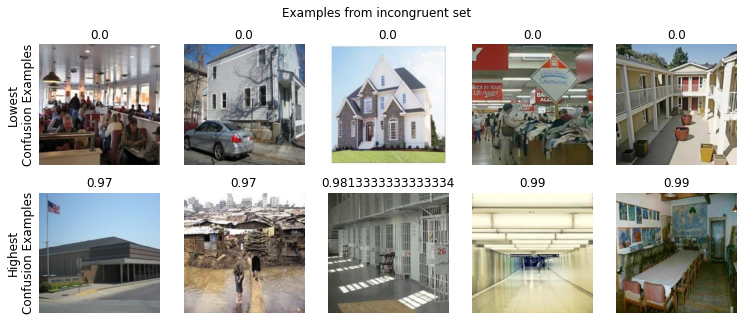

In [190]:
itrs = [
    ('congruent', congruent_df),
    ('incongruent', incongruent_df)
]
image_parent_dir = os.path.join('data', 'broden1_224', 'images')
confusion_metric = 'top_2_confusion'
n_display = 5
for congruency_str, df in itrs:
    sorted_df = df.sort_values(confusion_metric)

    lowest_df = sorted_df.iloc[:n_display]
    low_image_name = lowest_df['filename']
    low_image_paths = [os.path.join(image_parent_dir, image_name) for image_name in low_image_name]
    low_images = [load_image(path) for path in low_image_paths]
    low_confusions = list(lowest_df[confusion_metric])

    highest_df = sorted_df.iloc[-n_display:]
    high_image_name = highest_df['filename']
    high_image_paths = [os.path.join(image_parent_dir, image_name) for image_name in high_image_name]
    high_images = [load_image(path) for path in high_image_paths]
    high_confusions = list(highest_df[confusion_metric])
    print(low_confusions)
    show_image_rows(
        images=[low_images, high_images],
        image_titles=[low_confusions, high_confusions],
        row_labels=['Lowest\nConfusion Examples', 'Highest\nConfusion Examples'],
        figure_title='Examples from {} set'.format(congruency_str)
    )